**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1RaiYPz-2sS-EReNQL7tW6ms8ZuZphJLS?usp=sharing)

2. [Практика 1](https://colab.research.google.com/drive/1rd5i7URs1v_P8-KveFGFAQJ9thayJk1c?usp=sharing)

3. Практика 2

4. [Практика 3](https://colab.research.google.com/drive/1IX8zahyU01Nl0rm8dCsCrhY_l_UqDjRA?usp=sharing)


Теперь, когда теория и первая практика пройдены, перейдите к решению практической задачи – классификации музыкальных жанров на основании усреднения набора признаков. 

Начните с изучения базы для обучения. Это база из 1 000 записей, разделенная
на 10 жанров.

#Обработка аудиосигналов: Классификация музыкальных жанров
## (усреднение набора признаков)

##Импорт библиотек

In [ ]:
# Массивы
import numpy as np

# Отрисовка графиков
import matplotlib.pyplot as plt

# Связь с google диском
from google.colab import drive

# Загрузка из google облака
import gdown

# Преобразование категориальных данных в one hot encoding
from tensorflow.keras.utils import to_categorical

# Работа с папками и файлами
import os

# Утилиты работы со временем
import time

# Работа со случайными числами
import random

# Математические функции
import math

# Сохранение и загрузка структур данных Python
import pickle

# Параметризация аудио
import librosa

# Оптимизаторы для обучения моделей
from tensorflow.keras.optimizers import Adam, RMSprop

# Конструирование и загрузка моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model, load_model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

# Разбиение на обучающую и проверочную выборку
from sklearn.model_selection import train_test_split

# Кодирование категориальных меток, нормирование числовых данных
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

Поясним дополнительные подключенные инструменты:

* модуль **pickle** широко применяется в **Python** для сохранения и загрузки объектов сложной структуры;

* модуль **confusion_matrix** позволяет построить **_матрицу ошибок_**, классический инструмент для оценки качества работы моделей-классификаторов. О матрице ошибок речь пойдет далее в ноутбуке.
* Класс **ConfusionMatrixDisplay** отвечает за визуализацию матрицы ошибок в ячейке Colab;
* модуль **warnings** отвечает за контроль вывода предупреждений в **Python**. Конструкция `warnings.filterwarnings('ignore')` отключает предупреждения, чтобы не засоряли вывод.

##Загрузка датасета и подготовка данных

Начнем с изучения набора данных для обучения. Это база из **1000** аудиофайлов, по **100** записей в каждом из **10** музыкальных жанров.

Скачайте музыкальный датасет по ссылке:

In [ ]:
# Загрузка датасета из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l12/genres.zip', None, quiet=False)

'genres.zip'

Распакуйте архив, посмотрите содержимое папки.

В ней находятся **10** подпапок с примерами каждого музыкального жанра. В подпапке одного жанра содержите по **100** аудиофайлов.

In [ ]:
# Распаковка архива на локальный диск colab
!unzip -qo genres.zip

# Проверка выгруженных папок
!ls genres 

# Проверка содержимого одной папки
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

Определим константы, которые пригодятся в дальнейшем и сделают работу удобнее:

In [ ]:
# Установка констант

FILE_DIR = './genres'                     # Папка с файлами датасета
CLASS_LIST = os.listdir(FILE_DIR)         # Список классов, порядок меток не определен!
CLASS_LIST.sort()                         # Сортировка списка классов для фиксации порядка меток
CLASS_COUNT = len(CLASS_LIST)             # Количество классов
CLASS_FILES = 100                         # Общее количество файлов в каждом классе
FILE_INDEX_TRAIN_SPLIT = 90               # Количество файлов каждого класса на основной набор
VALIDATION_SPLIT = 0.1                    # Доля проверочной выборки в основном наборе
DURATION_SEC = 30                         # Анализируемая длительность аудиосигнала
N_FFT = 8192                              # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 512                          # Объем данных для расчета одного набора признаков

Проверим, правильно ли заполнились метки классов и отсортированы ли они по алфавиту:

In [ ]:
# Проверка списка классов
print(CLASS_LIST)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


Для дальнейшей работы создадим набор функций, которые будут использоваться неоднократно. Такой подход поможет избежать повторов кода и внесения ошибок.

Функция `get_features()` вычисляет выбранные признаки произвольного аудиофайла, собирает их в словарь и возвращает на выходе. В этой функции собираются следующие признаки:
* хромаграмма;
* мел-кепстральные коэффициенты;
* среднеквадратическая амплитуда;
* спектральный центроид;
* ширина полосы частот;
* спектральный спад частоты;
* скорость пересечения нуля.

Поскольку все признаки вычисляются по скользящему окну (по участку аудио в рамке, сдвигающейся на заданный шаг), то по каждому файлу будет рассчитано множество экземпляров каждого признака (более **1200**). В данном решении использована идея усреднения каждого признака по всем окнам, чтобы получить некое общее значение признака по всему файлу. 

Итого на один файл - по одному экземпляру каждого признака. Возникает вопрос, а какой результат даст использование полного набора признаков без усреднения? Эта идея реализована в следующем ноутбуке занятия.


In [ ]:
# Функция параметризации аудио

def get_features(y,                     # волновое представление сигнала
                 sr,                    # частота дискретизации сигнала y
                 n_fft=N_FFT,           # размер скользящего окна БПФ
                 hop_length=HOP_LENGTH  # шаг скользящего окна БПФ
                 ):
    # Вычисление различных параметров (признаков) аудио

    # Среднеквадратическая амплитуда
    rmse = librosa.feature.rms(y=y, hop_length=hop_length)
    # Спектральный центроид
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Ширина полосы частот
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Спектральный спад частоты
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Пересечения нуля
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)
    # Мел-кепстральные коэффициенты
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Хромаграмма
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    
    # Сборка параметров в общий список:
    # На один файл один усредненный вектор признаков
    features = {'rmse': rmse.mean(axis=1, keepdims=True),
                'spct': spec_cent.mean(axis=1, keepdims=True),
                'spbw': spec_bw.mean(axis=1, keepdims=True),
                'roff': rolloff.mean(axis=1, keepdims=True),
                'zcr' : zcr.mean(axis=1, keepdims=True),
                'mfcc': mfcc.mean(axis=1, keepdims=True),
                'stft': chroma_stft.mean(axis=1, keepdims=True)}

    return features

Следующая функция объединит набор признаков из словаря в общий массив. Признаки присоединяются к массиву по столбцам с помощью функции `vstack()` модуля **numpy**.

In [ ]:
# Функция объединения признаков в набор векторов

def stack_features(feat  # словарь признаков, отдельные векторы по ключу каждого признака
                   ):
    features = None
    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v

    return features.T

Проверим работу функции на одном звуковом файле. В итоге на выходе получается вектор из **37** элементов по порядку ключей словаря. В векторе эти значения будут иметь индексы:

* **0**: среднеквадратическая амплитуда - **1** значение;
* **1**: спектральный центроид - **1** значение;
* **2**: ширина полосы частот - **1** значение;
* **3**: спектральный спад частоты - **1** значение;
* **4**: скорость пересечения нуля - **1** значение;
* **5-24**: мел-частотные кепстральные коэффициенты - **20** значений;
* **25-36**: хромаграмма - **12** значений.

In [ ]:
# Проверка параметризации одного произведения
y, sr = librosa.load(f'{FILE_DIR}/blues/blues.00000.au', mono=True, duration=DURATION_SEC)
features = get_features(y, sr)

In [ ]:
print({k: v.shape for k, v in features.items()})

{'rmse': (1, 1), 'spct': (1, 1), 'spbw': (1, 1), 'roff': (1, 1), 'zcr': (1, 1), 'mfcc': (20, 1), 'stft': (12, 1)}


In [ ]:
# Проверка формирования набора признаков
feature_set = stack_features(features)
feature_set.shape

(1, 37)

Сконцентрируем код для подготовки данных в следующих удобных функциях:
* `get_feature_list_from_file()` – параметризация одного аудиофайла, возвращает набор признаков для файла и его метку класса в формате one-hot encoding;
* `process_file()` – формирование фрагмента выборки признаков для аудиофайла. Возвращает набор признаков и меток класса в виде массивов **numpy**;
* `extract_data()` – формирование полного набора данных для всех классов по множеству аудиофайлов, заданному диапазоном их индексов в датасете. Работа функции может быть долгой, поэтому добавлен вывод прогресса обработки.

In [ ]:
# Функция формирования набора признаков и метки класса для аудиофайла

def get_feature_list_from_file(class_index,  # индекс класса файла song_name
                               song_name,    # имя аудиофайла
                               duration_sec  # длительность аудио в секундах
                               ):
    # Загрузка в y первых duration_sec секунд аудиосигнала
    y, sr = librosa.load(song_name, mono=True, duration=duration_sec)

    # Извлечение параметров из аудиосигнала
    features = get_features(y, sr)
    feature_set = stack_features(features)

    # Перевод номера класса в one hot encoding
    y_label = to_categorical(class_index, CLASS_COUNT)

    return feature_set, y_label

In [ ]:
# Функция формирования подвыборки признаков и меток класса для одного файла

def process_file(class_index,  # индекс класса аудиофайла
                 file_index,   # индекс (порядковый номер) аудиофайла в папке класса
                 duration_sec  # длительность аудио в секундах
                 ):
    x_list = []
    y_list = []
    class_name = CLASS_LIST[class_index]

    # Извлечение имени произведения
    song_name = f'{FILE_DIR}/{class_name}/{class_name}.{str(file_index).zfill(5)}.au'

    # Выборка признаков и метки класса для произведения
    feature_set, y_label = get_feature_list_from_file(class_index, 
                                                        song_name,
                                                        duration_sec)

    # Добавление данных в наборы
    for j in range(feature_set.shape[0]):
        x_list.append(feature_set[j])
        y_list.append(y_label)

    # Возврат имени файла и numpy-массивов призанков и меток класса
    return song_name, \
           np.array(x_list).astype('float32'), \
           np.array(y_list).astype('float32')

In [ ]:
# Функция формирования набора данных из файлов всех классов по диапазону номеров файлов

def extract_data(file_index_start,          # начальный индекс аудиофайла
                 file_index_end,            # конечный индекс аудиофайла (не достигая)
                 duration_sec=DURATION_SEC  # длительность аудио в секундах
                 ):

    # Списки для последовательностей входных данных и меток класса
    x_data = None
    y_data = None

    # Фиксация времени старта формирования выборки
    curr_time = time.time()

    # Для всех классов:
    for class_index in range(len(CLASS_LIST)):
        # Для всех файлов текущего класса из заданного диапазона номеров:
        for file_index in range(file_index_start, file_index_end):
            # Обработка одного файла и добавление данных к общим массивам
            _, file_x_data, file_y_data = process_file(class_index, file_index, duration_sec)
            x_data = file_x_data if x_data is None else np.vstack([x_data, file_x_data])
            y_data = file_y_data if y_data is None else np.vstack([y_data, file_y_data])

        # Вывод информации о готовности обработки датасета
        print(f'Жанр {CLASS_LIST[class_index]} готов -> {round(time.time() - curr_time)} c')
        curr_time = time.time()

    # Возврат массивов набора данных
    return x_data, y_data

Теперь воспользуемся разработанными функциями для создания обучающего набора:

In [ ]:
# Формирование тренировочного (основного) набора данных
x_train_data, y_train_data = extract_data(0, FILE_INDEX_TRAIN_SPLIT)

Жанр blues готов -> 155 c
Жанр classical готов -> 149 c
Жанр country готов -> 156 c
Жанр disco готов -> 147 c
Жанр hiphop готов -> 141 c
Жанр jazz готов -> 141 c
Жанр metal готов -> 143 c
Жанр pop готов -> 147 c
Жанр reggae готов -> 149 c
Жанр rock готов -> 145 c


Когда параметризация данных занимает значительное время, полезно сохранить ваши выборки для дальнейшего использования; при повторных пусках можно будет пропустить генерацию и загрузить уже рассчитанные выборки из файла.

In [ ]:
# Сохранение/восстановление датасета аудио
# Данные привязаны к порядку следования меток классов!
# Порядок классов фиксирован сортировкой списка меток классов
with open('/content/audio_data_mean.pickle', 'wb') as f:
    pickle.dump((x_train_data, y_train_data), f)

with open('/content/audio_data_mean.pickle', 'rb') as f:
    x_train_data, y_train_data = pickle.load(f)

Проверьте метки классов в наборе: поскольку классы обрабатывались один за другим, метки классов в наборе **y_train** будут следовать в том же порядке:

In [ ]:
# Вывод номеров классов для проверки правильности заполнения
# Номера классов идут последовательно крупными блоками
print(np.argmax(y_train_data, axis=1))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 

Проверьте форму данных выборок:

In [ ]:
# Вывод формы данных обучающего набора
print(x_train_data.shape, x_train_data.dtype)
print(y_train_data.shape, y_train_data.dtype)

(900, 37) float32
(900, 10) float32


Нормализуйте входные данные основного набора **x_train_data** при помощи инструмента **StandardScaler** из библиотеки **sklearn**:

In [ ]:
# Нормирование признаков в соответствии со стандартным нормальным распределением
x_scaler = StandardScaler()
x_train_data_scaled = x_scaler.fit_transform(x_train_data)

Разделите данные основного набора на обучающую и проверочную выборки для обучения модели:

In [ ]:
# Разделение набора данных на обучающую и проверочную выборки
# Параметр stratify указывает метки классов, по которым происходит балансировка разделения
x_train, x_val, y_train, y_val = train_test_split(x_train_data_scaled,
                                                  y_train_data,
                                                  stratify=y_train_data,
                                                  test_size=VALIDATION_SPLIT)

Проверьте результат нормирования данных и форму полученных выборок:

In [ ]:
# Проверка нормирования
print(x_train[0])

[-1.1621561  -1.8275064  -1.7311226  -1.9096898  -1.6138009  -1.8131027
  2.0945349   0.5965211  -0.41671786  0.6275855  -0.06844911  1.5100318
 -0.10803711 -0.66536033 -0.4902339  -0.4328911  -0.9508615  -0.21402153
 -1.5109673  -0.85694736 -1.330854    0.65809846 -1.3891697  -0.31483877
 -0.56783277 -0.70796496  0.12876853 -1.2702918  -0.19790232 -0.8591743
  0.1157854  -1.0447112  -1.2573122  -0.01066898 -1.2399516  -0.11122319
 -1.1816123 ]


In [ ]:
# Проверка формы и типа данных обучающей и проверочной выборок
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print()
print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(810, 37) float32
(810, 10) float32

(90, 37) float32
(90, 10) float32


Перед созданием модели нейронной сети убедитесь, что данные сбалансированы по классам и в них нет перекоса. 

Для этого постройте гистограммы по обучающей и проверочной выборкам:

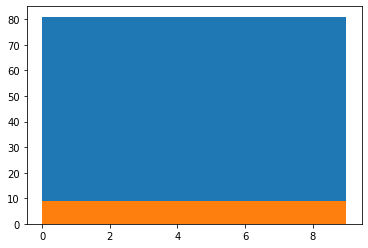

In [ ]:
# Проверка сбалансированности выборок по классам
plt.hist(np.argmax(y_train, axis=1), CLASS_COUNT)
plt.hist(np.argmax(y_val, axis=1), CLASS_COUNT)
plt.show()

Данные распределены по классам равномерно, выборки сбалансированы.

Итак, данные для обучения подготовлены!

Можно переходить к созданию модели и ее обучению.

##Модель нейронной сети

Соберем создание, вывод сводки модели, обучение и вывод графиков обучения в одной функции.

Нейросеть будет состоять из полносвязных слоев с применением пакетной нормализации и dropout:

In [ ]:
# Функция сборки и обучения классификатора на полносвязных слоях

def create_train_classifier(in_shape,      # форма входных данных модели
                            epochs=200,    # количество эпох обучения
                            batch_size=20  # размер батча
                            ):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=in_shape))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(CLASS_COUNT, activation='softmax'))

    # Компиляция модели
    model.compile(optimizer=Adam(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model.summary()

    # Обучение модели
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графика точности распознавания на обучающей и проверочной выборках
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
    plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    plt.xticks(range(0, epochs, 10))
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()

    return model

Обучим модель и посмотрим на ход обучения:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               9728      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

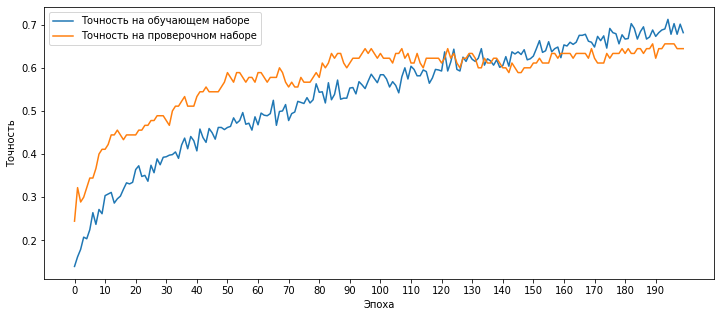

In [ ]:
model = create_train_classifier(x_train.shape[1:])

Можно видеть, что точность после **200** эпох достигает **65%**.

Сохраните модель и выборки для дальнейших экспериментов:

In [ ]:
# Сохранение/восстановление модели и выборок

model.save('/content/model_audio_mean.h5')
with open('/content/audio_train_val_mean.pickle', 'wb') as f:
    pickle.dump((x_train, y_train, x_val, y_val, x_scaler), f)

model = load_model('/content/model_audio_mean.h5')
with open('/content/audio_train_val_mean.pickle', 'rb') as f:
    x_train, y_train, x_val, y_val, x_scaler = pickle.load(f)

Модель готова и обучена, некоторая точность получена, задача классификации звука в прицнипе решена.

Впереди трудный путь подбора гиперпараметров и архитектуры нейронной сети для улучшения результативности модели. Но как организовать этот процесс?

Рассмотрим проверку точности предсказаний модели и способы дальнейшего ее усовершенствования.

##Проверка точности предсказаний модели

###Проверка на данных тестовой выборки

Сформируем тестовую выборку из данных, которые никогда не предъявлялись модели - это аудиофайлы с индексами от **FILE_INDEX_TRAIN_SPLIT** до последнего:

In [ ]:
# Формирование тестовой выборки из файлов, не вошедших в основной набор

x_test, y_test = extract_data(FILE_INDEX_TRAIN_SPLIT, CLASS_FILES)
x_test = x_scaler.transform(x_test)

Жанр blues готов -> 16 c
Жанр classical готов -> 16 c
Жанр country готов -> 16 c
Жанр disco готов -> 16 c
Жанр hiphop готов -> 16 c
Жанр jazz готов -> 16 c
Жанр metal готов -> 16 c
Жанр pop готов -> 16 c
Жанр reggae готов -> 16 c
Жанр rock готов -> 16 c


Сконцентрируем код оценки точности модели в функции `eval_model()`:

* При помощи `model.evaluate()` получим результат ошибки и точности модели на заданной выборке.

 >Отличие `model.evaluate()` от `model.predict()` в возвращаемых результатах. `model.predict()` вернет собственно предсказание НС, `model.evaluate()` вычислит предсказание, сравнит его с верными ответами и вернет ошибку и метрики точности модели.

* Рассчитаем матрицу ошибок на основании предсказаний НС:
 * `confusion_matrix()` – расчет матрицы ошибок;
 * `np.argmax(y_true, axis=1)` – метки классов правильных ответов;
 * `np.argmax(y_pred, axis=1)` – метки классов, предсказанных моделью;
 * `normalize='true'` – указание нормализации данных матрицы.

* При помощи `ConfusionMatrixDisplay()` выведем матрицу ошибок в ячейку Colab.

In [ ]:
# Функция оценки точности модели на заданной выборке

def eval_model(model,  # обученная модель нейронной сети
               x,      # входные данные
               y_true  # выходные данные (верные ответы)
               ):
    loss, acc = model.evaluate(x, y_true)
    print(f'Ошибка: {loss}, точность: {acc}')

    # Построение матрицы ошибок
    y_pred = model.predict(x)
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок нормализованная')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()    

Воспользуемся функцией `eval_model()` для оценки результатов только что обученной полносвязной модели.

Сначала на проверочной выборке:

3/3 [==============================] - 0s 5ms/step - loss: 1.0191 - accuracy: 0.6444
Ошибка: 1.019097089767456, точность: 0.644444465637207


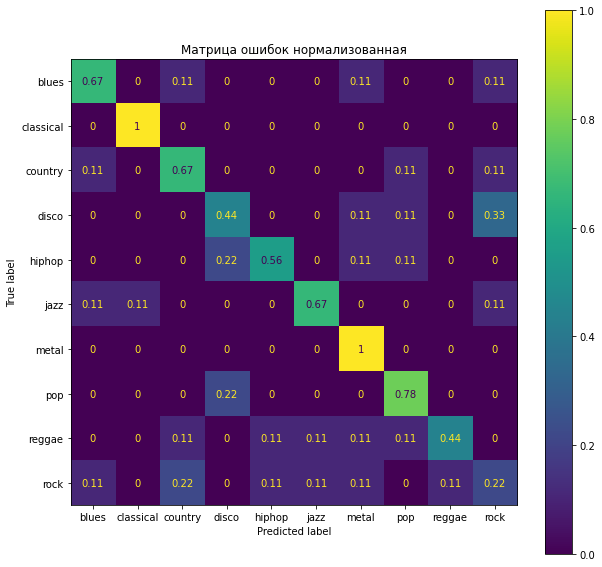

In [ ]:
# Оценка точности сети на проверочной выборке
eval_model(model, x_val, y_val)

А затем - на тестовой выборке:

4/4 [==============================] - 0s 4ms/step - loss: 1.1527 - accuracy: 0.5700
Ошибка: 1.152714490890503, точность: 0.5699999928474426


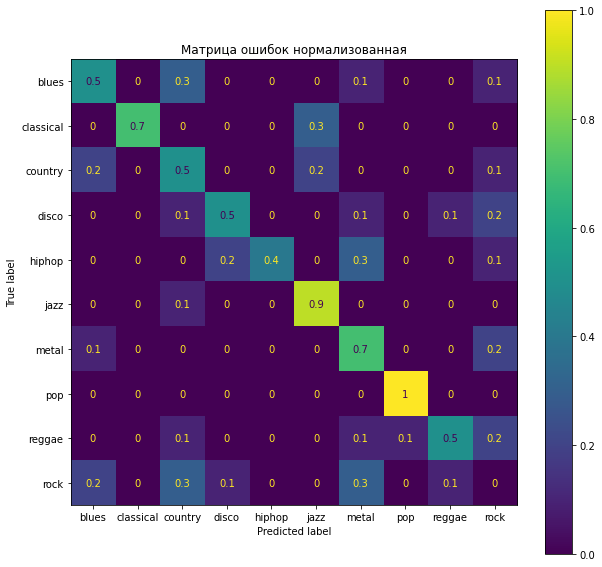

In [ ]:
# Оценка точности сети на тестовой выборке
eval_model(model, x_test, y_test)

Интерпретировать матрицу ошибок несложно. По вертикальной оси показаны правильные метки классов (жанров музыки), по горизонтали – метки, предсказанные моделью.

Для примера рассмотрим ячейку **blues/blues** со значением **0.5**. Число **0.5** в нормализованной матрице означает, что **50%** записей жанра блюз предсказаны моделью как блюз, что верно. Проследим дальше по горизонтали: остальные **50%** блюзовых примеров были распознаны моделью как кантри (**0.2 / 20%**), джаз (**0.1 / 10%**), метал (**0.1 / 10%**) и рок (**0.1 / 10%**). Эти результаты распознавания ошибочны.

Рассмотрим ячейку **classical/classical** со значением **1**. Значение **1** означает, что нейронная сеть
распознала все записи правильно (**100%**).

Также можно видеть, что изучаемая модель хуже всего классифицирует жанр рок - верно не распознано ни одного примера, ошибочные предсказания больше всего распределились на жанры метал и кантри.

Общая логика нормализованной матрицы ошибок проста: чем ближе к **1** диагональные значения - тем лучше. Соответственно, в других ячейках матрицы (ошибочные распознавания) значения должны быть как можно меньше.

---
Идеальной матрицей ошибок для данной задачи была бы **_единичная матрица_** **10 x 10**:

```
1 0 0 0 0 0 0 0 0 0
0 1 0 0 0 0 0 0 0 0
0 0 1 0 0 0 0 0 0 0
0 0 0 1 0 0 0 0 0 0
0 0 0 0 1 0 0 0 0 0
0 0 0 0 0 1 0 0 0 0
0 0 0 0 0 0 1 0 0 0
0 0 0 0 0 0 0 1 0 0
0 0 0 0 0 0 0 0 1 0
0 0 0 0 0 0 0 0 0 1
```

---

Как читать *ненормализованную* матрицу ошибок? Тоже ничего сложного. В ненормализованной матрице в ячейках посчитаны примеры данных по штукам, а в нормализованной - их доли к общему числу, вот и вся разница. Напрммер, если при оценке распознавалось **10** треков жанра блюз, то вместо **0.5** стояло бы **5**: пять треков из десяти модель классифицировала правильно.

Более верно проверять точность на отдельных файлах, как при промышленной эксплуатации модели.

---

**Важно:** с прикладной точки зрения вернее проверять точность модели на звуковых файлах.

---

Как обычно, сконцентрируем код для проверки точности на файлах в следующих функциях:
* `classify_file()` – классифицирует отдельный звуковой файл и выводит результат работы модели. Результат будет выводиться в виде гистограммы распределения степени уверенности модели в отнесении файла к каждому классу;
* `classify_test_files()` – классифицирует набор файлов всех классов, заданный диапазоном индексов файлов. По завершении строит ненормализованную матрицу ошибок (по штукам) для всего заданного набора файлов.

In [ ]:
# Классификация файла и визуализация предсказания модели для него

def classify_file(model,        # обученная модель классификатора
                  x_scaler,     # настроенный нормировщих входных данных
                  class_index,  # верный индекс класса аудиофайла
                  file_index    # индекс (порядковый номер) аудиофайла в папке
                  ):
    # Подготовка выборки данных файла произведения
    song_name, file_x_data, file_y_data = process_file(class_index, file_index, DURATION_SEC)
    # Нормирование признаков уже настроенным нормировщиком
    file_x_data = x_scaler.transform(file_x_data)

    print('Файл:', song_name)
    print('Векторы для предсказания:', file_x_data.shape)

    # Вычисление предсказания по выборке
    predict = model.predict(file_x_data)
    # Определение среднего предсказания (голосование)
    predict_mean = predict.mean(axis=0)
    # Определение индекса класса по результату голосования
    predict_class_index = np.argmax(predict_mean)
    # Вычисление признака правильного предсказания
    predict_good = predict_class_index == class_index

    # Визуализация предсказания сети для файла
    plt.figure(figsize=(10,3))
    print('Классификация сети:', CLASS_LIST[predict_class_index], '-', 'ВЕРНО :-)' if predict_good else 'НЕВЕРНО.')
    plt.title('Среднее распределение векторов предсказаний')
    plt.bar(CLASS_LIST, predict_mean, color='g' if predict_good else 'r')
    plt.show()
    print('---------------------------------------------------------------')

    # Возврат результата предсказания
    return predict_class_index

In [ ]:
# Классификация и визуализация нескольких файлов каждого класса 

def classify_test_files(model,       # обученная модель классификатора
                        x_scaler,    # настроенный нормировщих входных данных
                        from_index,  # индекс аудиофайла, с которого начинать визуализацию
                        n_files):    # количество файлов для визуализации
    predict_all = 0
    predict_good = 0
    y_true = []
    y_pred = []
    for class_index in range(CLASS_COUNT):
        for file_index in range(from_index, from_index + n_files):
            predict_class_index = classify_file(model, x_scaler, class_index, file_index)
            y_true.append(class_index)
            y_pred.append(predict_class_index)
            predict_all += 1
            predict_good += (predict_class_index == class_index)

    # Расчет и вывод итогов классификации
    good_ratio = round(predict_good / predict_all * 100., 2)
    print(f'=== Обработано образцов: {predict_all}, из них распознано верно: {predict_good}, доля верных: {good_ratio}% ===')   

    # Построение матрицы ошибок без нормализации, покажет попадания в штуках
    cm = confusion_matrix(y_true, y_pred)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок по файлам аудио (не нормализованная)')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()

###Визуализация на файлах тренировочного набора

Изучим точность и устойчивость классификации модели на примерах обучающего набора (здесь: по **5** файлов каждого класса начиная с индекса **50**):

Файл: ./genres/blues/blues.00050.au
Векторы для предсказания: (1, 37)
Классификация сети: blues - ВЕРНО :-)


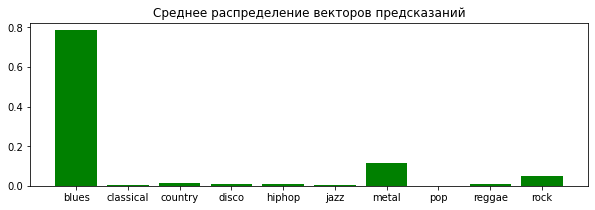

---------------------------------------------------------------
Файл: ./genres/blues/blues.00051.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - НЕВЕРНО.


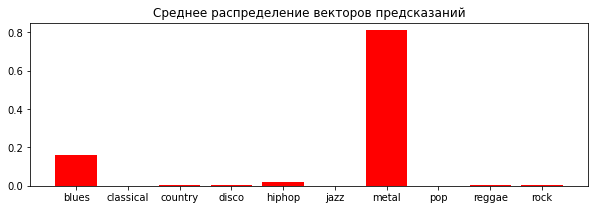

---------------------------------------------------------------
Файл: ./genres/blues/blues.00052.au
Векторы для предсказания: (1, 37)
Классификация сети: blues - ВЕРНО :-)


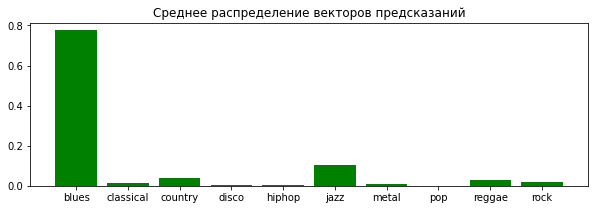

---------------------------------------------------------------
Файл: ./genres/blues/blues.00053.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - НЕВЕРНО.


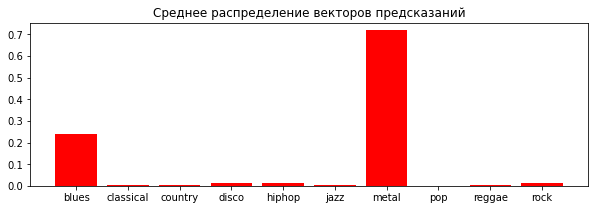

---------------------------------------------------------------
Файл: ./genres/blues/blues.00054.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - НЕВЕРНО.


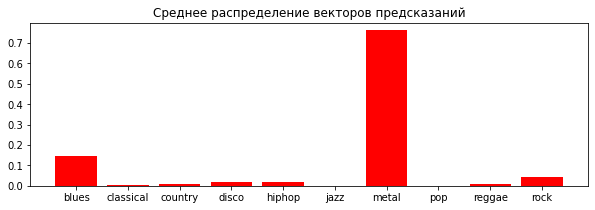

---------------------------------------------------------------
Файл: ./genres/classical/classical.00050.au
Векторы для предсказания: (1, 37)
Классификация сети: classical - ВЕРНО :-)


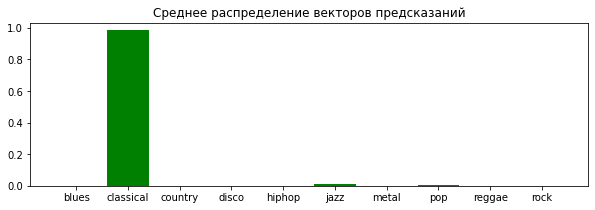

---------------------------------------------------------------
Файл: ./genres/classical/classical.00051.au
Векторы для предсказания: (1, 37)
Классификация сети: reggae - НЕВЕРНО.


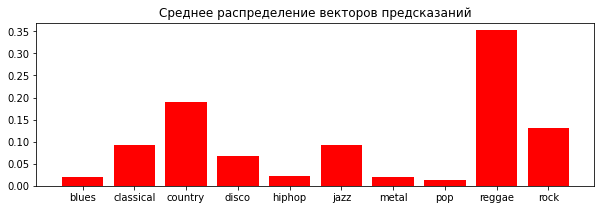

---------------------------------------------------------------
Файл: ./genres/classical/classical.00052.au
Векторы для предсказания: (1, 37)
Классификация сети: classical - ВЕРНО :-)


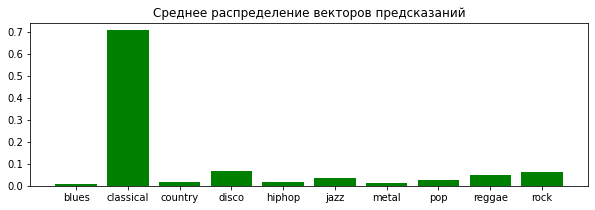

---------------------------------------------------------------
Файл: ./genres/classical/classical.00053.au
Векторы для предсказания: (1, 37)
Классификация сети: classical - ВЕРНО :-)


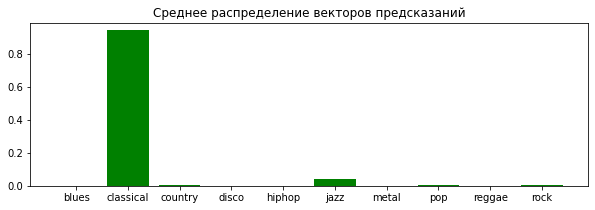

---------------------------------------------------------------
Файл: ./genres/classical/classical.00054.au
Векторы для предсказания: (1, 37)
Классификация сети: classical - ВЕРНО :-)


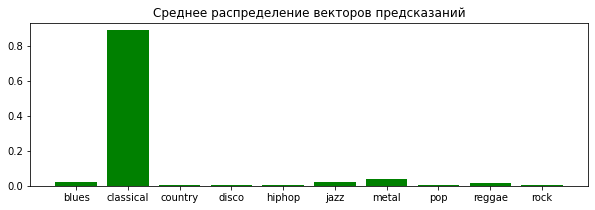

---------------------------------------------------------------
Файл: ./genres/country/country.00050.au
Векторы для предсказания: (1, 37)
Классификация сети: country - ВЕРНО :-)


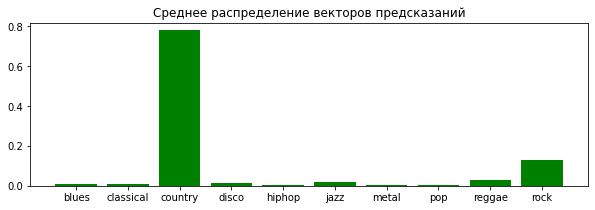

---------------------------------------------------------------
Файл: ./genres/country/country.00051.au
Векторы для предсказания: (1, 37)
Классификация сети: country - ВЕРНО :-)


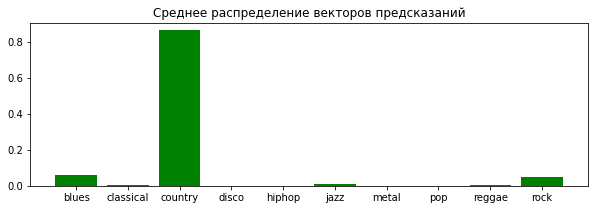

---------------------------------------------------------------
Файл: ./genres/country/country.00052.au
Векторы для предсказания: (1, 37)
Классификация сети: country - ВЕРНО :-)


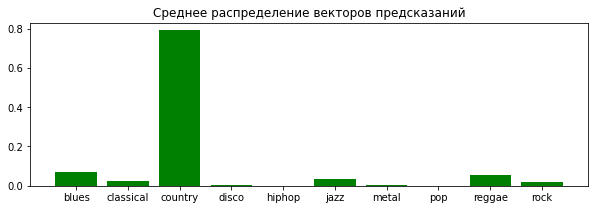

---------------------------------------------------------------
Файл: ./genres/country/country.00053.au
Векторы для предсказания: (1, 37)
Классификация сети: country - ВЕРНО :-)


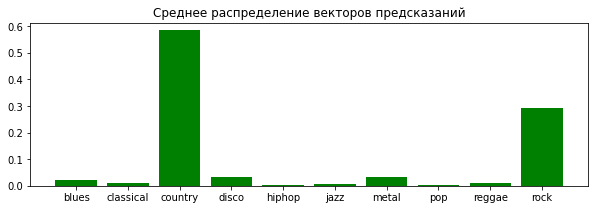

---------------------------------------------------------------
Файл: ./genres/country/country.00054.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - НЕВЕРНО.


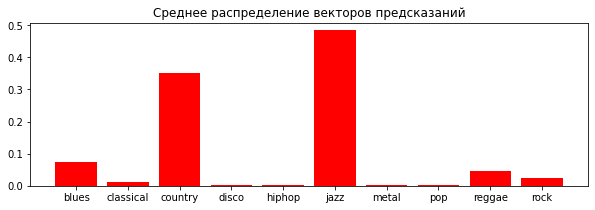

---------------------------------------------------------------
Файл: ./genres/disco/disco.00050.au
Векторы для предсказания: (1, 37)
Классификация сети: disco - ВЕРНО :-)


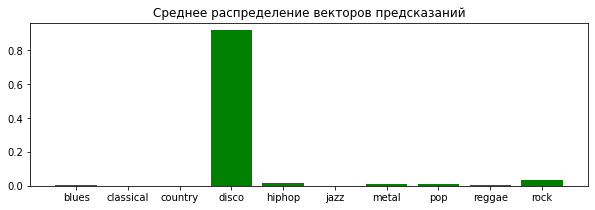

---------------------------------------------------------------
Файл: ./genres/disco/disco.00051.au
Векторы для предсказания: (1, 37)
Классификация сети: disco - ВЕРНО :-)


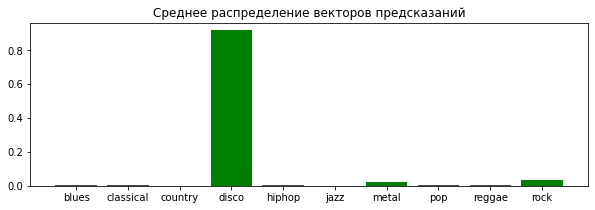

---------------------------------------------------------------
Файл: ./genres/disco/disco.00052.au
Векторы для предсказания: (1, 37)
Классификация сети: disco - ВЕРНО :-)


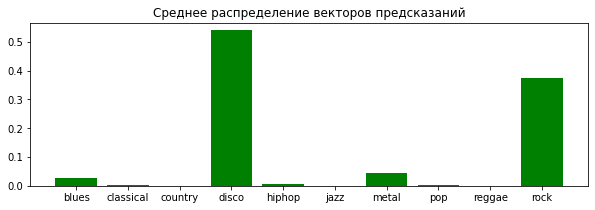

---------------------------------------------------------------
Файл: ./genres/disco/disco.00053.au
Векторы для предсказания: (1, 37)
Классификация сети: disco - ВЕРНО :-)


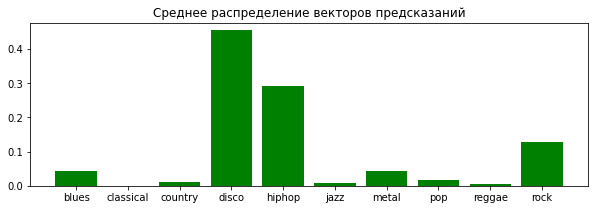

---------------------------------------------------------------
Файл: ./genres/disco/disco.00054.au
Векторы для предсказания: (1, 37)
Классификация сети: disco - ВЕРНО :-)


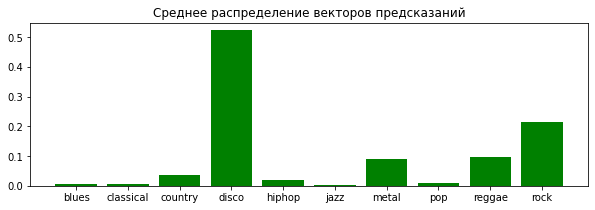

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00050.au
Векторы для предсказания: (1, 37)
Классификация сети: hiphop - ВЕРНО :-)


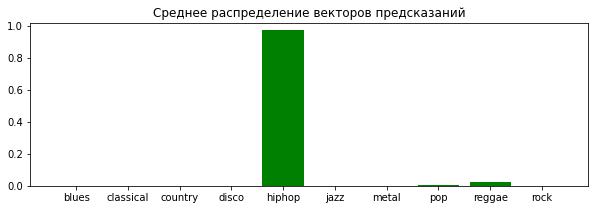

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00051.au
Векторы для предсказания: (1, 37)
Классификация сети: hiphop - ВЕРНО :-)


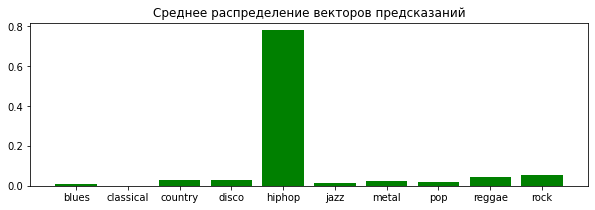

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00052.au
Векторы для предсказания: (1, 37)
Классификация сети: hiphop - ВЕРНО :-)


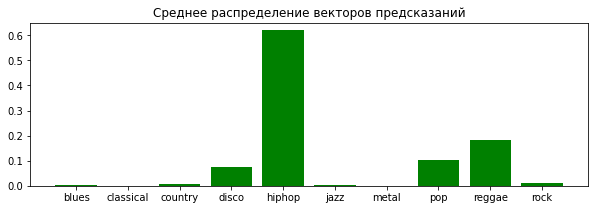

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00053.au
Векторы для предсказания: (1, 37)
Классификация сети: hiphop - ВЕРНО :-)


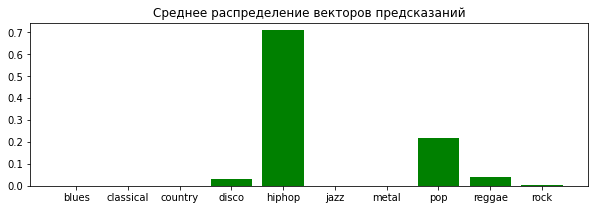

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00054.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - НЕВЕРНО.


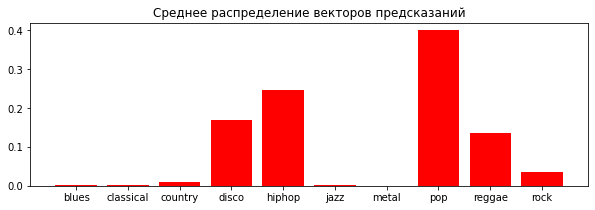

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00050.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - ВЕРНО :-)


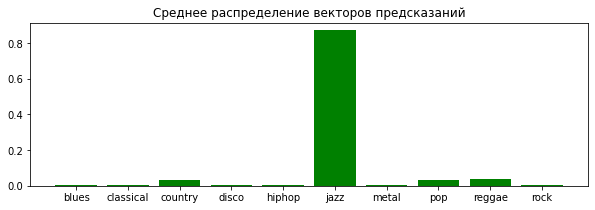

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00051.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - ВЕРНО :-)


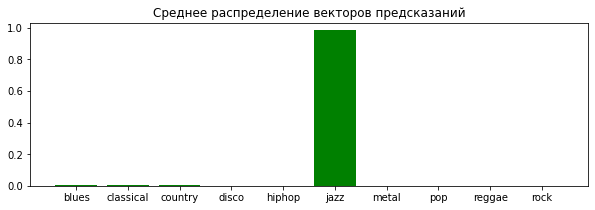

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00052.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - ВЕРНО :-)


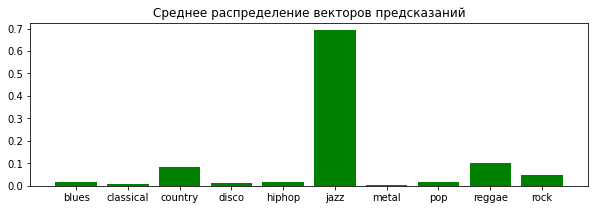

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00053.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - ВЕРНО :-)


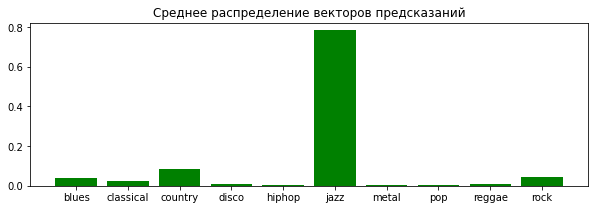

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00054.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - ВЕРНО :-)


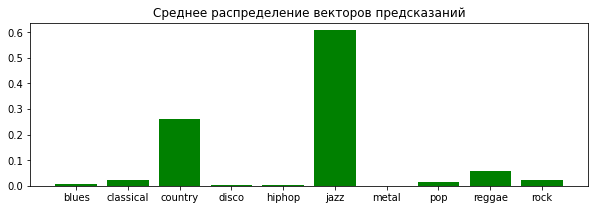

---------------------------------------------------------------
Файл: ./genres/metal/metal.00050.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - ВЕРНО :-)


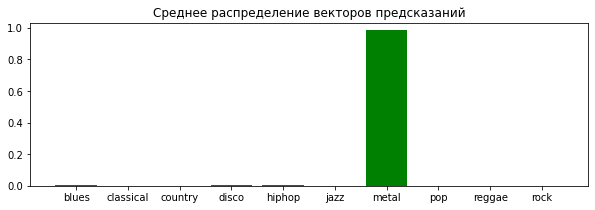

---------------------------------------------------------------
Файл: ./genres/metal/metal.00051.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - ВЕРНО :-)


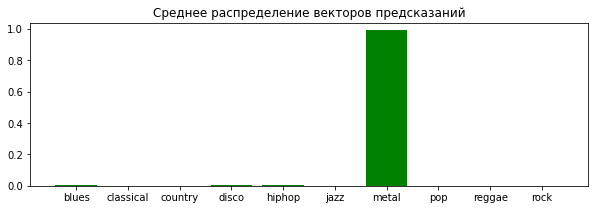

---------------------------------------------------------------
Файл: ./genres/metal/metal.00052.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - ВЕРНО :-)


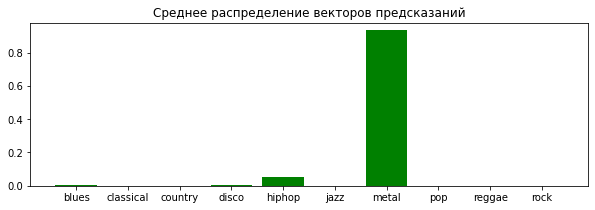

---------------------------------------------------------------
Файл: ./genres/metal/metal.00053.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - ВЕРНО :-)


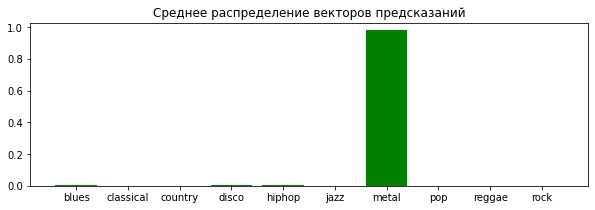

---------------------------------------------------------------
Файл: ./genres/metal/metal.00054.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - ВЕРНО :-)


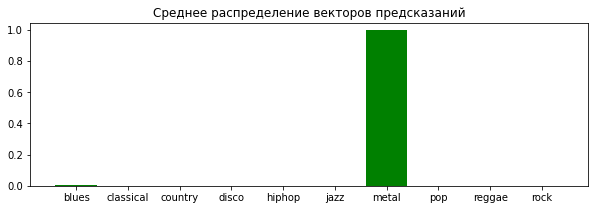

---------------------------------------------------------------
Файл: ./genres/pop/pop.00050.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - ВЕРНО :-)


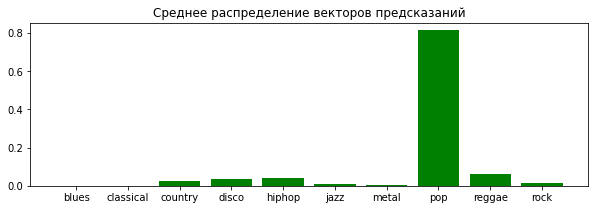

---------------------------------------------------------------
Файл: ./genres/pop/pop.00051.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - ВЕРНО :-)


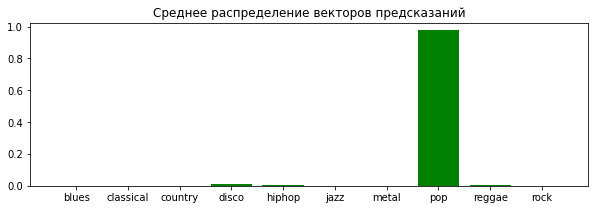

---------------------------------------------------------------
Файл: ./genres/pop/pop.00052.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - ВЕРНО :-)


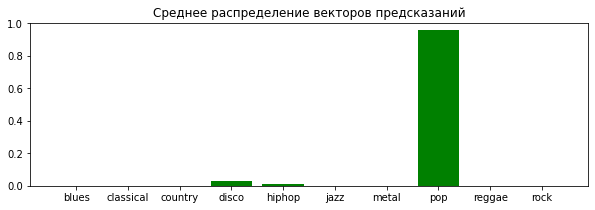

---------------------------------------------------------------
Файл: ./genres/pop/pop.00053.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - ВЕРНО :-)


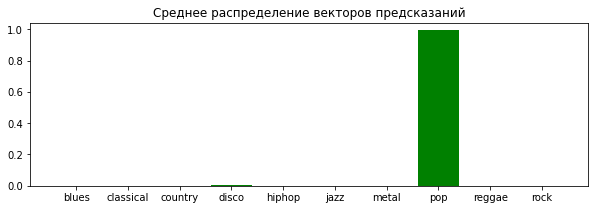

---------------------------------------------------------------
Файл: ./genres/pop/pop.00054.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - ВЕРНО :-)


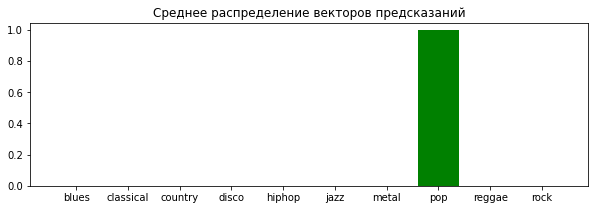

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00050.au
Векторы для предсказания: (1, 37)
Классификация сети: reggae - ВЕРНО :-)


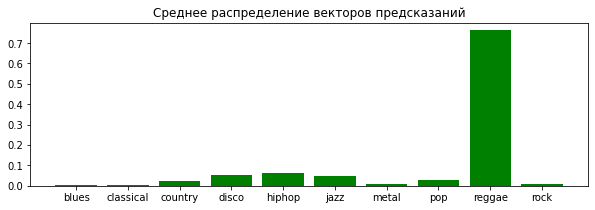

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00051.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - НЕВЕРНО.


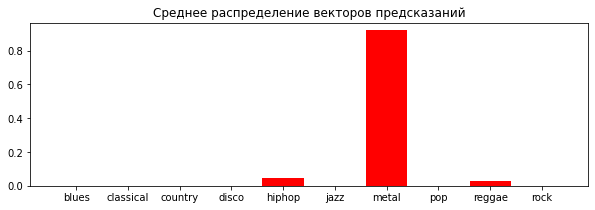

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00052.au
Векторы для предсказания: (1, 37)
Классификация сети: hiphop - НЕВЕРНО.


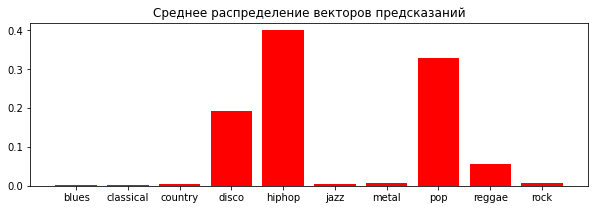

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00053.au
Векторы для предсказания: (1, 37)
Классификация сети: reggae - ВЕРНО :-)


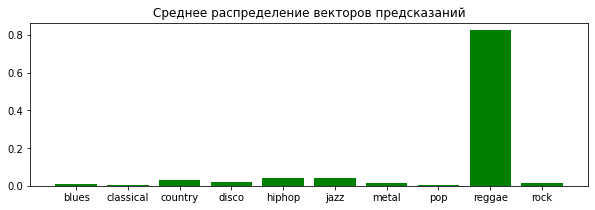

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00054.au
Векторы для предсказания: (1, 37)
Классификация сети: reggae - ВЕРНО :-)


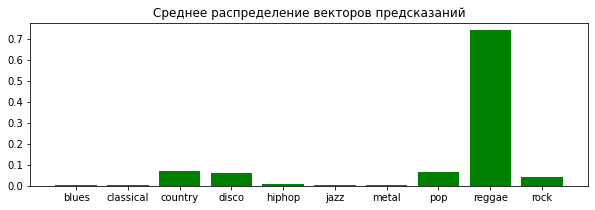

---------------------------------------------------------------
Файл: ./genres/rock/rock.00050.au
Векторы для предсказания: (1, 37)
Классификация сети: reggae - НЕВЕРНО.


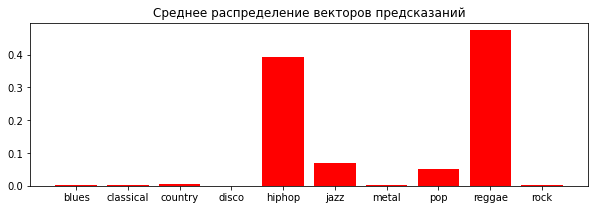

---------------------------------------------------------------
Файл: ./genres/rock/rock.00051.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - НЕВЕРНО.


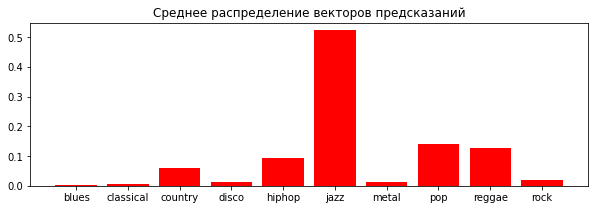

---------------------------------------------------------------
Файл: ./genres/rock/rock.00052.au
Векторы для предсказания: (1, 37)
Классификация сети: rock - ВЕРНО :-)


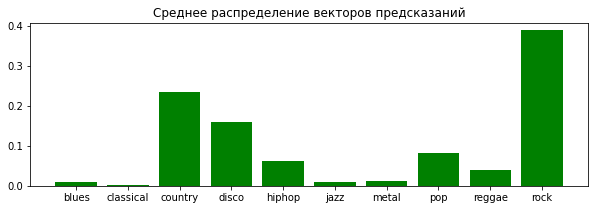

---------------------------------------------------------------
Файл: ./genres/rock/rock.00053.au
Векторы для предсказания: (1, 37)
Классификация сети: rock - ВЕРНО :-)


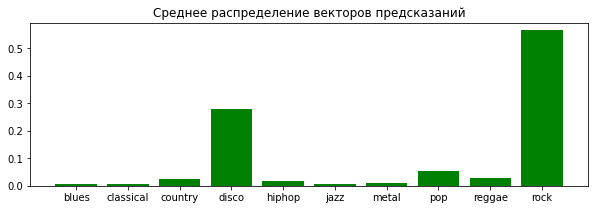

---------------------------------------------------------------
Файл: ./genres/rock/rock.00054.au
Векторы для предсказания: (1, 37)
Классификация сети: rock - ВЕРНО :-)


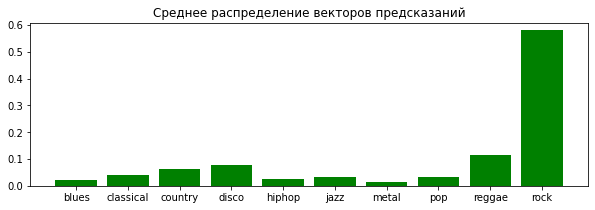

---------------------------------------------------------------
=== Обработано образцов: 50, из них распознано верно: 40, доля верных: 80.0% ===


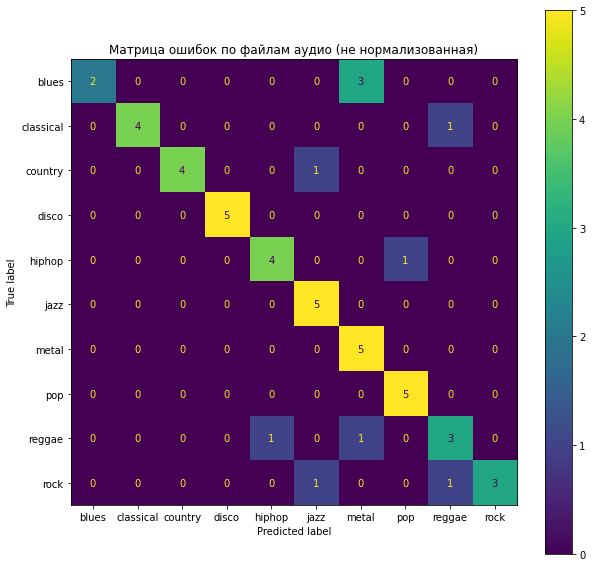

In [ ]:
# Визуализация классификации файлов из тренировочного набора
classify_test_files(model, x_scaler, 50, 5)

###Визуализация на файлах тестового набора

Сделаем то же самое на файлах тестового набора (по **5** файлов каждого класса, начиная от индекса **95**, имея в виду, что индексы тестовых файлов начинаются с **90**):

Файл: ./genres/blues/blues.00095.au
Векторы для предсказания: (1, 37)
Классификация сети: blues - ВЕРНО :-)


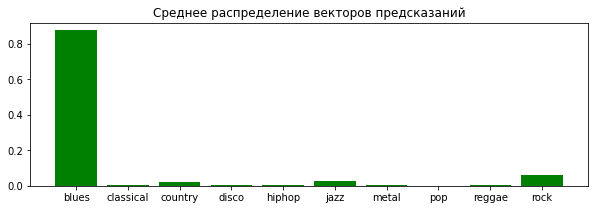

---------------------------------------------------------------
Файл: ./genres/blues/blues.00096.au
Векторы для предсказания: (1, 37)
Классификация сети: country - НЕВЕРНО.


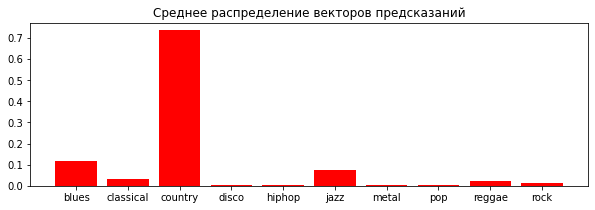

---------------------------------------------------------------
Файл: ./genres/blues/blues.00097.au
Векторы для предсказания: (1, 37)
Классификация сети: blues - ВЕРНО :-)


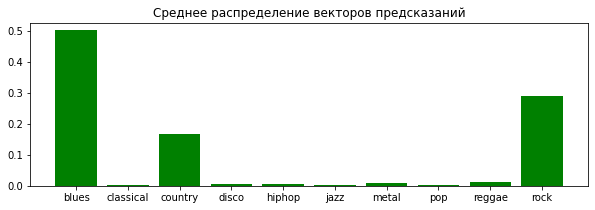

---------------------------------------------------------------
Файл: ./genres/blues/blues.00098.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - НЕВЕРНО.


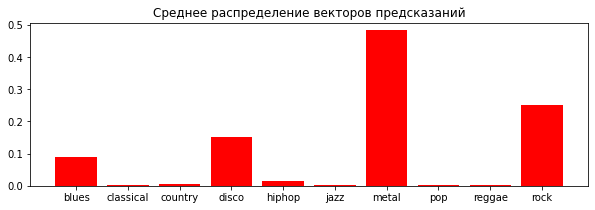

---------------------------------------------------------------
Файл: ./genres/blues/blues.00099.au
Векторы для предсказания: (1, 37)
Классификация сети: rock - НЕВЕРНО.


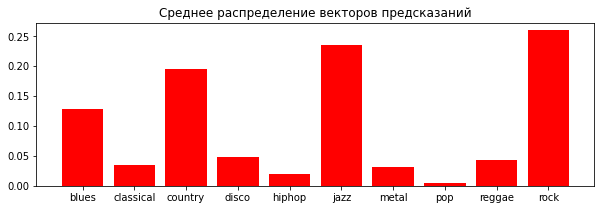

---------------------------------------------------------------
Файл: ./genres/classical/classical.00095.au
Векторы для предсказания: (1, 37)
Классификация сети: classical - ВЕРНО :-)


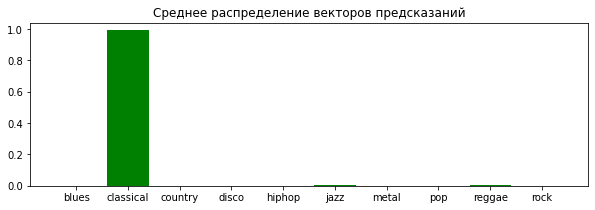

---------------------------------------------------------------
Файл: ./genres/classical/classical.00096.au
Векторы для предсказания: (1, 37)
Классификация сети: classical - ВЕРНО :-)


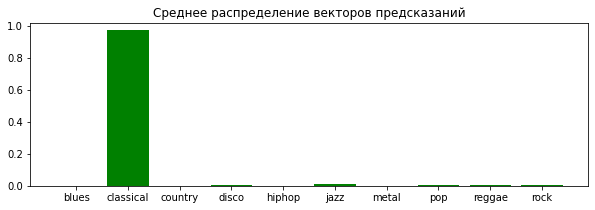

---------------------------------------------------------------
Файл: ./genres/classical/classical.00097.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - НЕВЕРНО.


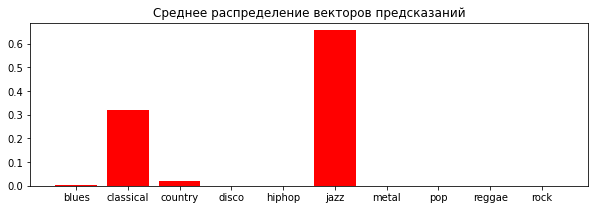

---------------------------------------------------------------
Файл: ./genres/classical/classical.00098.au
Векторы для предсказания: (1, 37)
Классификация сети: classical - ВЕРНО :-)


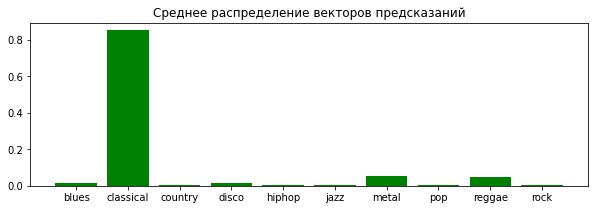

---------------------------------------------------------------
Файл: ./genres/classical/classical.00099.au
Векторы для предсказания: (1, 37)
Классификация сети: classical - ВЕРНО :-)


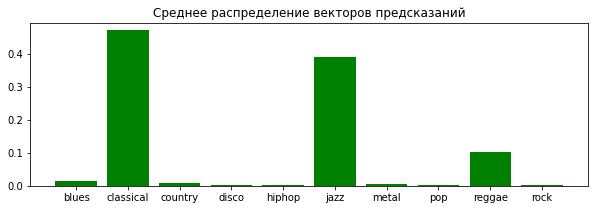

---------------------------------------------------------------
Файл: ./genres/country/country.00095.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - НЕВЕРНО.


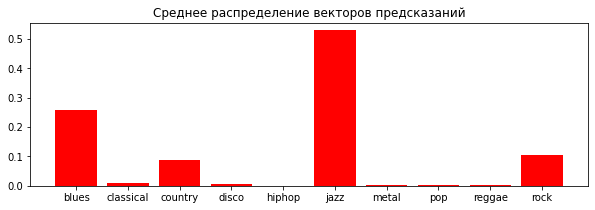

---------------------------------------------------------------
Файл: ./genres/country/country.00096.au
Векторы для предсказания: (1, 37)
Классификация сети: country - ВЕРНО :-)


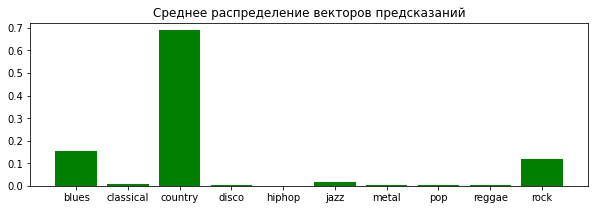

---------------------------------------------------------------
Файл: ./genres/country/country.00097.au
Векторы для предсказания: (1, 37)
Классификация сети: country - ВЕРНО :-)


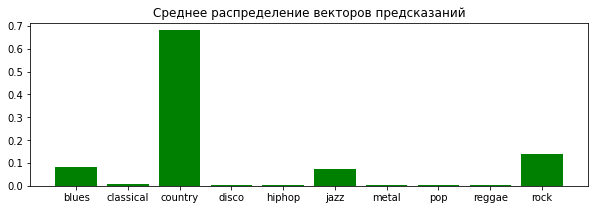

---------------------------------------------------------------
Файл: ./genres/country/country.00098.au
Векторы для предсказания: (1, 37)
Классификация сети: blues - НЕВЕРНО.


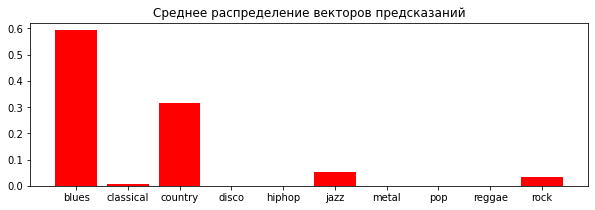

---------------------------------------------------------------
Файл: ./genres/country/country.00099.au
Векторы для предсказания: (1, 37)
Классификация сети: rock - НЕВЕРНО.


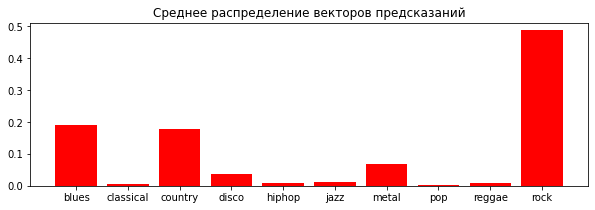

---------------------------------------------------------------
Файл: ./genres/disco/disco.00095.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - НЕВЕРНО.


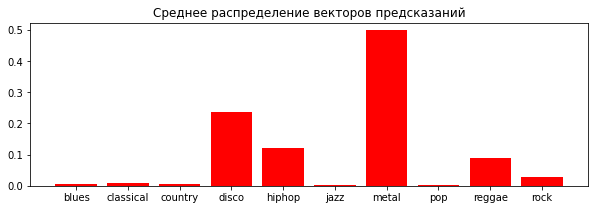

---------------------------------------------------------------
Файл: ./genres/disco/disco.00096.au
Векторы для предсказания: (1, 37)
Классификация сети: rock - НЕВЕРНО.


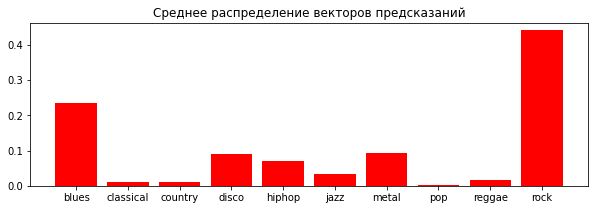

---------------------------------------------------------------
Файл: ./genres/disco/disco.00097.au
Векторы для предсказания: (1, 37)
Классификация сети: reggae - НЕВЕРНО.


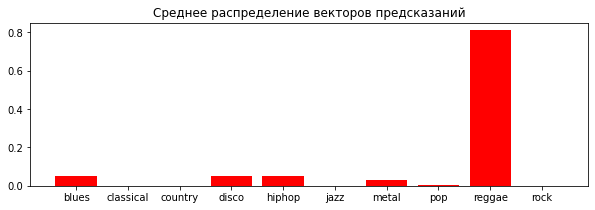

---------------------------------------------------------------
Файл: ./genres/disco/disco.00098.au
Векторы для предсказания: (1, 37)
Классификация сети: disco - ВЕРНО :-)


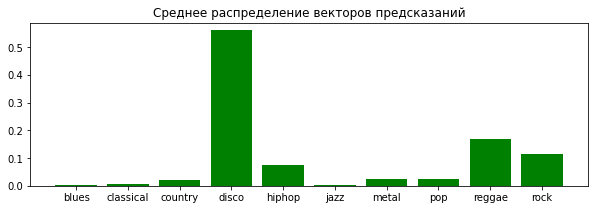

---------------------------------------------------------------
Файл: ./genres/disco/disco.00099.au
Векторы для предсказания: (1, 37)
Классификация сети: disco - ВЕРНО :-)


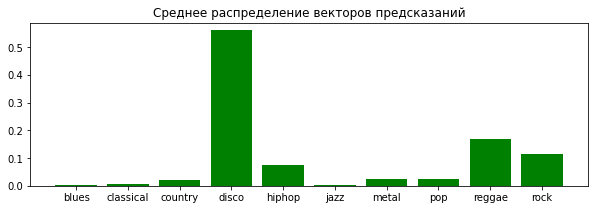

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00095.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - НЕВЕРНО.


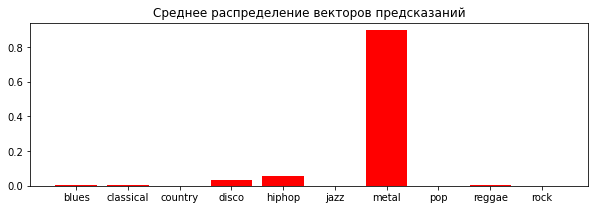

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00096.au
Векторы для предсказания: (1, 37)
Классификация сети: hiphop - ВЕРНО :-)


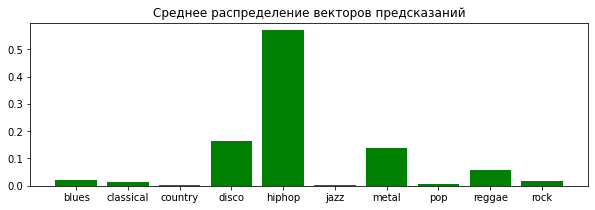

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00097.au
Векторы для предсказания: (1, 37)
Классификация сети: disco - НЕВЕРНО.


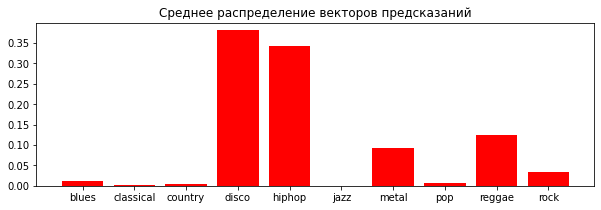

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00098.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - НЕВЕРНО.


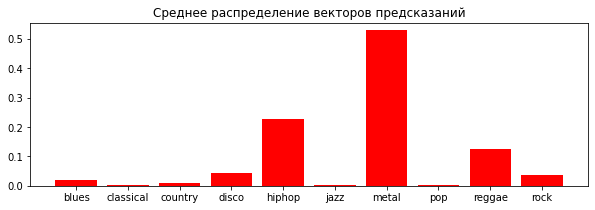

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00099.au
Векторы для предсказания: (1, 37)
Классификация сети: rock - НЕВЕРНО.


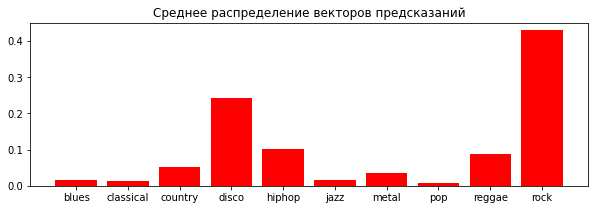

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00095.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - ВЕРНО :-)


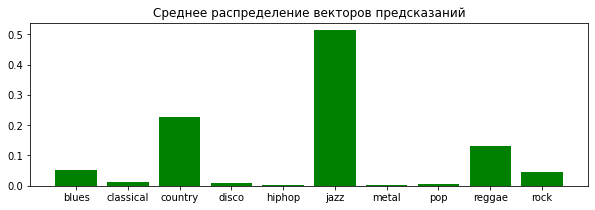

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00096.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - ВЕРНО :-)


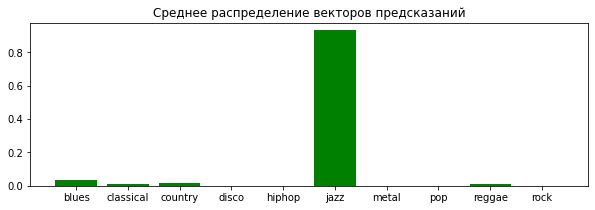

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00097.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - ВЕРНО :-)


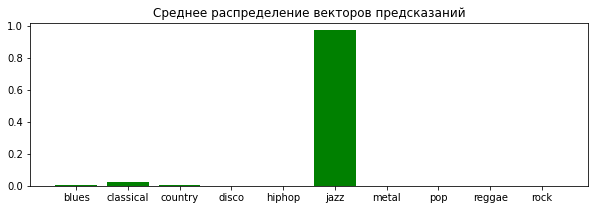

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00098.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - ВЕРНО :-)


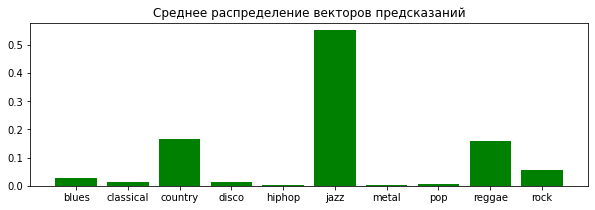

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00099.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - ВЕРНО :-)


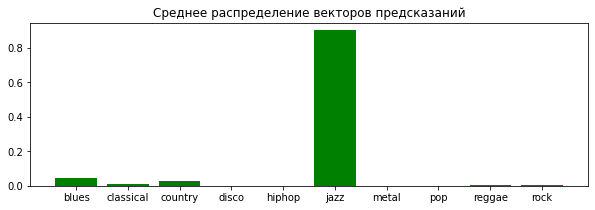

---------------------------------------------------------------
Файл: ./genres/metal/metal.00095.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - ВЕРНО :-)


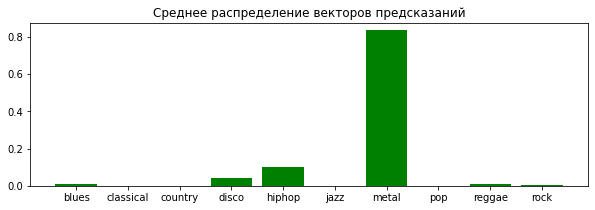

---------------------------------------------------------------
Файл: ./genres/metal/metal.00096.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - ВЕРНО :-)


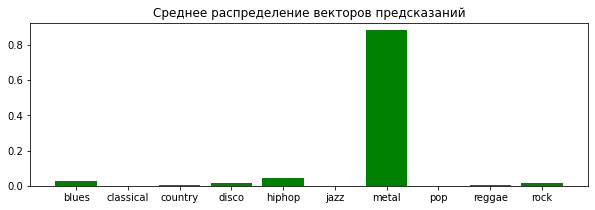

---------------------------------------------------------------
Файл: ./genres/metal/metal.00097.au
Векторы для предсказания: (1, 37)
Классификация сети: rock - НЕВЕРНО.


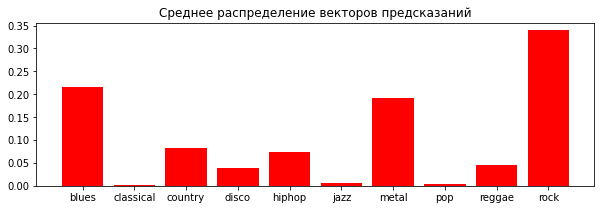

---------------------------------------------------------------
Файл: ./genres/metal/metal.00098.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - ВЕРНО :-)


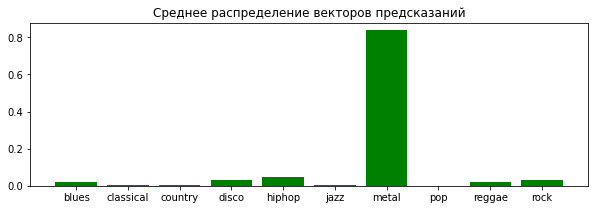

---------------------------------------------------------------
Файл: ./genres/metal/metal.00099.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - ВЕРНО :-)


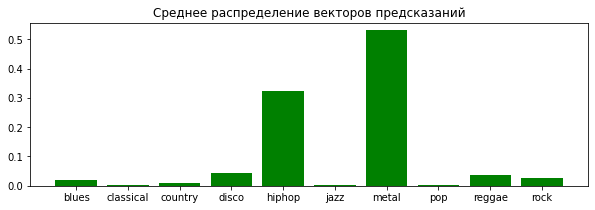

---------------------------------------------------------------
Файл: ./genres/pop/pop.00095.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - ВЕРНО :-)


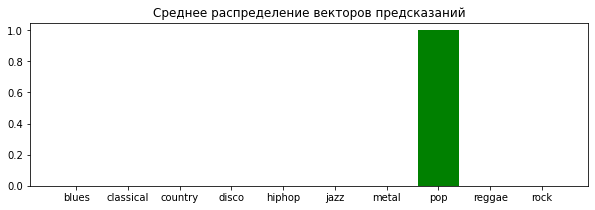

---------------------------------------------------------------
Файл: ./genres/pop/pop.00096.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - ВЕРНО :-)


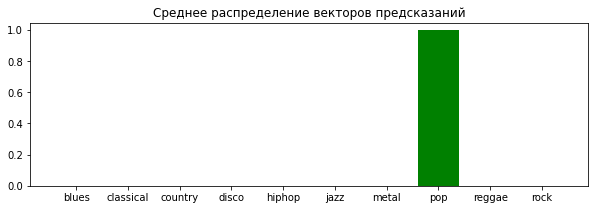

---------------------------------------------------------------
Файл: ./genres/pop/pop.00097.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - ВЕРНО :-)


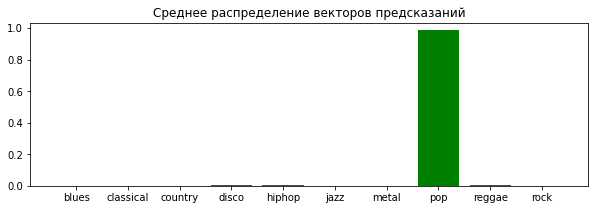

---------------------------------------------------------------
Файл: ./genres/pop/pop.00098.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - ВЕРНО :-)


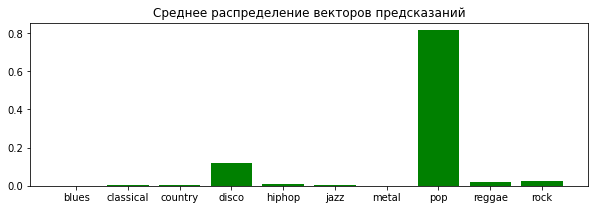

---------------------------------------------------------------
Файл: ./genres/pop/pop.00099.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - ВЕРНО :-)


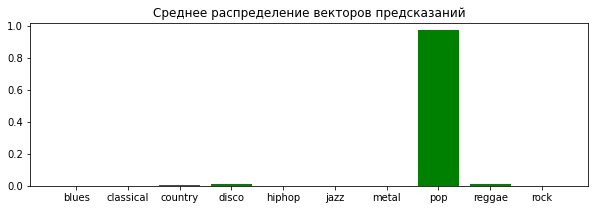

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00095.au
Векторы для предсказания: (1, 37)
Классификация сети: rock - НЕВЕРНО.


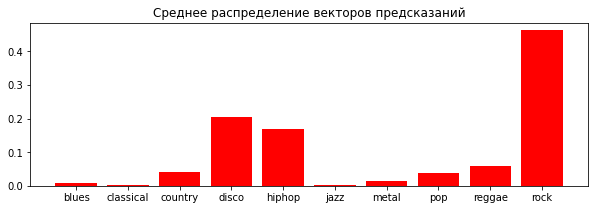

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00096.au
Векторы для предсказания: (1, 37)
Классификация сети: reggae - ВЕРНО :-)


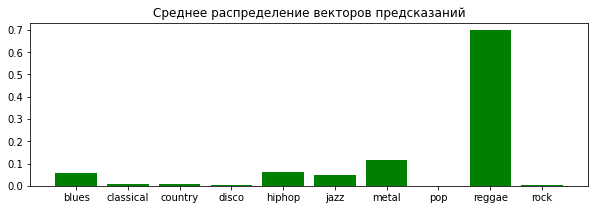

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00097.au
Векторы для предсказания: (1, 37)
Классификация сети: rock - НЕВЕРНО.


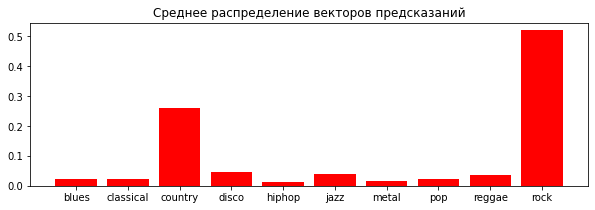

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00098.au
Векторы для предсказания: (1, 37)
Классификация сети: reggae - ВЕРНО :-)


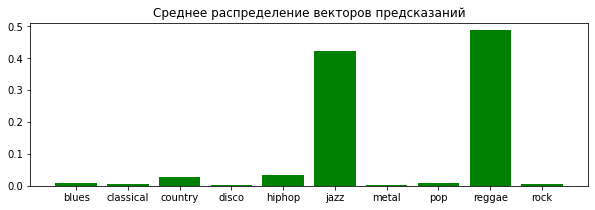

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00099.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - НЕВЕРНО.


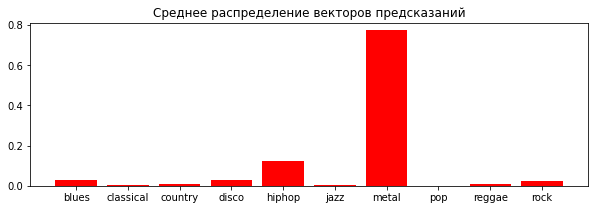

---------------------------------------------------------------
Файл: ./genres/rock/rock.00095.au
Векторы для предсказания: (1, 37)
Классификация сети: country - НЕВЕРНО.


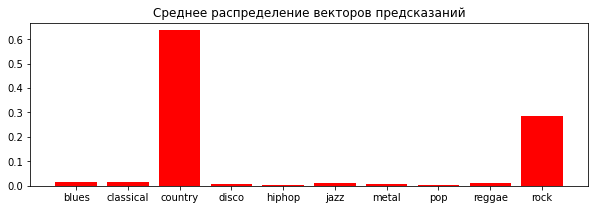

---------------------------------------------------------------
Файл: ./genres/rock/rock.00096.au
Векторы для предсказания: (1, 37)
Классификация сети: country - НЕВЕРНО.


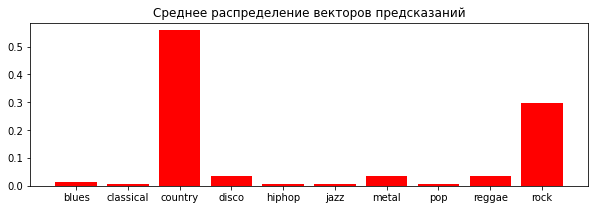

---------------------------------------------------------------
Файл: ./genres/rock/rock.00097.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - НЕВЕРНО.


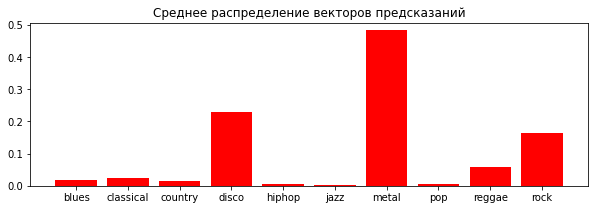

---------------------------------------------------------------
Файл: ./genres/rock/rock.00098.au
Векторы для предсказания: (1, 37)
Классификация сети: country - НЕВЕРНО.


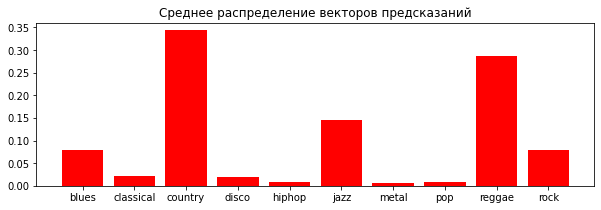

---------------------------------------------------------------
Файл: ./genres/rock/rock.00099.au
Векторы для предсказания: (1, 37)
Классификация сети: blues - НЕВЕРНО.


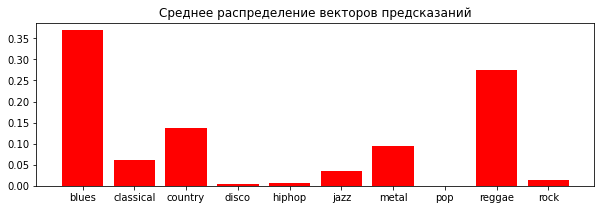

---------------------------------------------------------------
=== Обработано образцов: 50, из них распознано верно: 27, доля верных: 54.0% ===


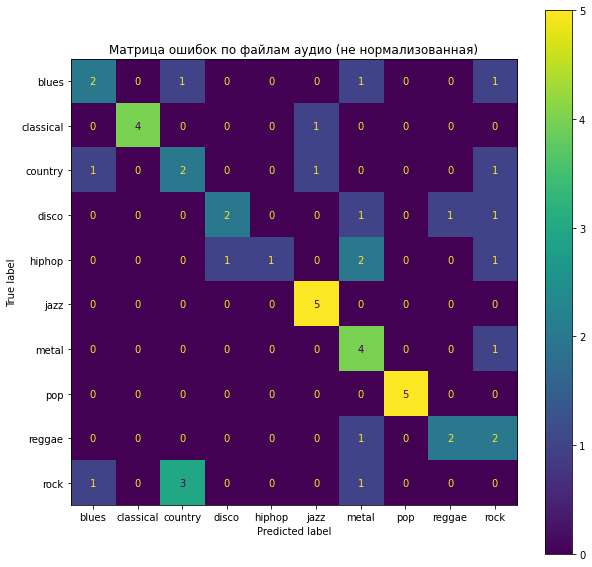

In [ ]:
# Визуализация классификации файлов из тестового набора
classify_test_files(model, x_scaler, 95, 5)

##Методика подбора значимых параметров для обучения модели

Естественным образом возникает вопрос - а все ли параметры нужны для качественного распознавания и какие из них нужнее?

Ответ на этот вопрос не является очевидным. Одна из попыток приблизиться к ответу в изучаемой задаче предпринята далее.


Испытаем следующий подход: возьмем малую модель и 
обучим ее с одинаковыми тренировочными параметрами, но на различных подмножествах входных признаков. Те признаки, на которых малая модель будет обучаться быстрее и давать лучшую точность, и будем считать значимыми. Будут ли отобранные параметры лучше и для большой модели? Возможно, но не обязательно - на большой модели нужны будут дополнительные проверки, но данный метод позволит отсечь параметры, которые скорее всего не дают значимой информации для исследуемого типа архитектур.

Напишем функцию `create_train_small_classifier()` для создания, обучения и визуализации результатов малой модели нейронной сети на полносвязных слоях. Особенностью функции будет то, что она будет создавать и обучать малую модель только для части входных признаков; эта часть задается индексами признаков в списке **index_list** на входе функции.

Вспомним, что в ранее определенной функции параметризации аудио `get_features()` признаки добавляются в следующем порядке индексов:

* **0**: 'rmse' - Среднеквадратическая амплитуда;
* **1**: 'spct' - Спектральный центроид;
* **2**: 'spbw' - Ширина полосы частот;
* **3**: 'roff' - Спектральный спад частоты;
* **4**: 'zcr' - Пересечения нуля;
* **5-24**: 'mfcc' - Мел-кепстральные коэффициенты (**20** признаков);
* **25-36**: 'stft' - Хромаграмма (**12** признаков).

In [ ]:
# Функция создания и обучения упрощенной архитектуры классификатора

def create_train_small_classifier(index_list,       # список номеров признаков в списке
                                  x_train=x_train,  # обучающая выборка - вход
                                  y_train=y_train,  # обучающая выборка - выход
                                  x_val=x_val,      # проверочная выборка - вход
                                  y_val=y_val,      # проверочная выборка - выход
                                  epochs=120,       # количество эпох обучения
                                  batch_size=20,    # размер батча
                                  verbose=0         # подробность вывода при обучении
                                  ):
    # Сборка модели
    model = Sequential()
    model.add(Dense(200, activation='elu', input_shape=(len(index_list),)))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    # Обучение модели на подмножестве признаков
    history = model.fit(x_train[:, index_list],
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=verbose,
                        validation_data=(x_val[:, index_list], y_val))

    # Вывод графика точности распознавания на обучающей и проверочной выборках
    plt.figure(figsize=(12,5))
    plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
    plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    plt.xticks(range(0, epochs, 10))
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()
    print('Точность в конце обучения:',
          history.history['accuracy'][-1],
          history.history['val_accuracy'][-1])
    
    return model

Теперь испытаем малую модель на различных подмножествах входных признаков, указывая их индексы явно или диапазоном:

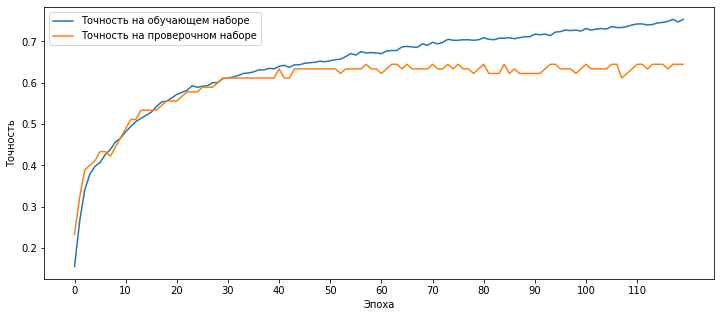

Точность в конце обучения: 0.7530864477157593 0.644444465637207


In [ ]:
# Обучение малой модели: все параметры
model_small = create_train_small_classifier(range(0, 37))

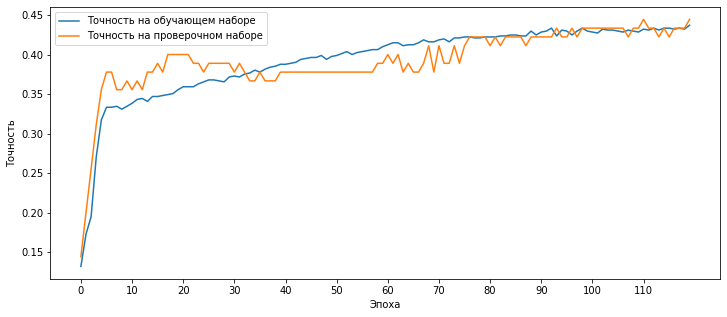

Точность в конце обучения: 0.43703705072402954 0.4444444477558136


In [ ]:
# Обучение малой модели: все параметры кроме мел-коэффициентов и хромаграммы
model_small = create_train_small_classifier(range(0, 5))

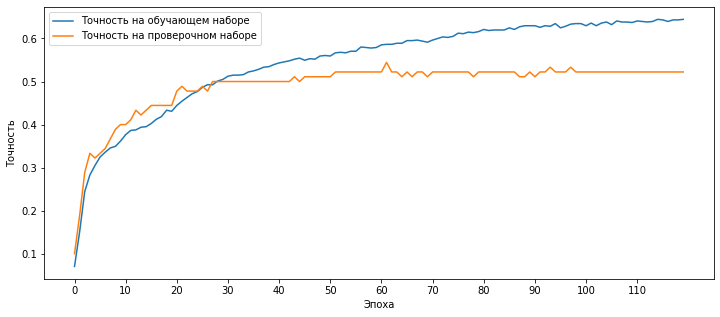

Точность в конце обучения: 0.644444465637207 0.5222222208976746


In [ ]:
# Обучение малой модели: только мел-коэффициенты
model_small = create_train_small_classifier(range(5, 25))

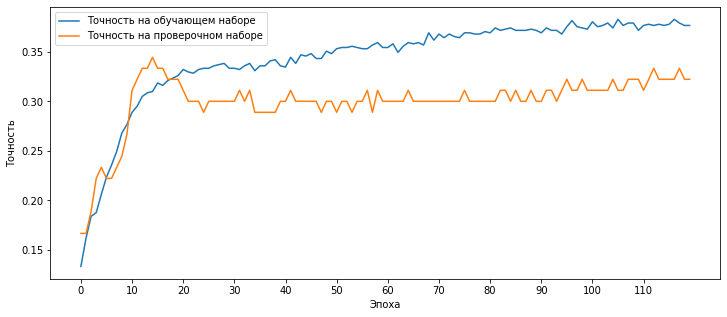

Точность в конце обучения: 0.37654322385787964 0.3222222328186035


In [ ]:
# Обучение малой модели: только хромаграмма
model_small = create_train_small_classifier(range(25, 37))

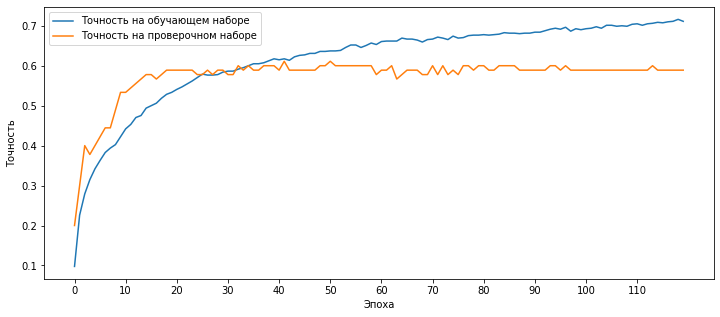

Точность в конце обучения: 0.7111111283302307 0.5888888835906982


In [ ]:
# Обучение малой модели: мел-коэффициенты и хромаграмма
model_small = create_train_small_classifier(range(5, 37))

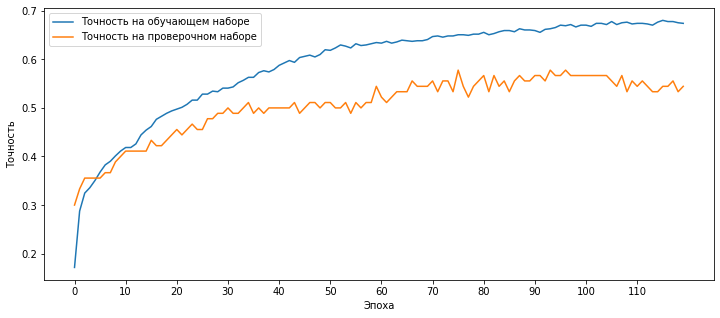

Точность в конце обучения: 0.6740740537643433 0.5444444417953491


In [ ]:
# Обучение малой модели: все параметры кроме хромаграммы
model_small = create_train_small_classifier(range(0, 25))

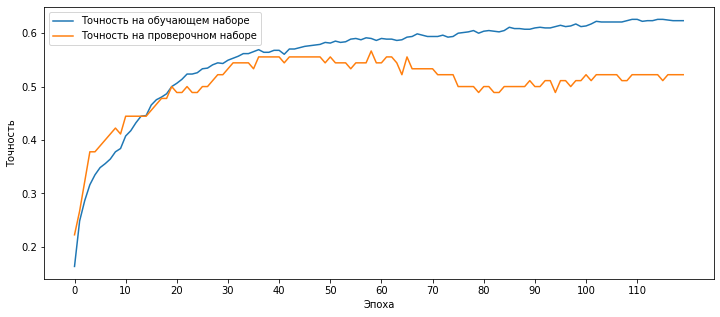

Точность в конце обучения: 0.6234567761421204 0.5222222208976746


In [ ]:
# Обучение малой модели: все параметры с шагом 2
model_small = create_train_small_classifier(range(0, 37, 2))

Подбирая состав признаков, можно предположить их влияние на точность обучения модели.

По проведенным опытам возможно сделать вывод, что признаки, при исключении которых точность падает почти вдвое, жизненно необходимы для обучения. А те, при исключении которых точность не уменьшается или даже растет, стоит убрать.

Испытаем еще один способ повышения точности модели - если выборка небольшая, имеет смысл использовать аугментацию данных.

##Пример аугментации данных для повышения точности классификации

Расширим данные путем их модификации с помощью нелинейных математических преобразований. С линейными нейросеть отлично справится и сама, а вот нелинейные преобразования зачастую способны выявить дополнительные свойства данных для анализа моделью.

В следующем примере аугментация производится над значением каждого признака поэлементно:
* возведение значения в квадрат;
* взятие квадратного корня из модуля значения;
* обратная величина к значению;
* 2 в степени значения.

Добавим новые (модифицированные) данные к исходному набору по строкам при помощи функции `hstack()` модуля **numpy**:

In [ ]:
# Все операции в данном блоке выполняются поэлементно; в результате получаются массивы той же формы

# Квадрат значений
x_train_data_sqr = x_train_data ** 2

# Квадратный корень из модулей значений
x_train_data_sqrt = np.abs(x_train_data) ** 0.5

# Обратная величина
x_train_data_inv = 1. / x_train_data

# 2 в степени каждого значения
x_train_data_exp = 2. ** x_train_data

# Формирование нового тренировочного набора данных
x_train_data_aug = np.hstack([x_train_data, x_train_data_sqr, x_train_data_sqrt, x_train_data_exp])

# Проверка формы данных нового набора
print(x_train_data_aug.shape)

(900, 148)


Данные могут получиться и очень большими по величине; их необходимо подготовить для работы с НС. Для этого
бесконечные числа заменим на **0** и нормализуем объединенный набор данных. При нормализации здесь не будет искажения данных, потому что за основу был использован ненормализованный исходный набор **x_train_data**.

In [ ]:
# Нормирование признаков в соответствии со стандартным нормальным распределением
# Замена всех бесконечных значений на 0, иначе нормирование невозможно
x_train_data_aug[np.abs(x_train_data_aug) == math.inf] = 0

x_scaler_aug = StandardScaler()
x_train_data_aug_scaled = x_scaler_aug.fit_transform(x_train_data_aug)

Вновь разделим данные на обучающую и проверочную выборки:

In [ ]:
# Разделение набора данных на обучающую и проверочную выборки
x_train_aug, x_val_aug, y_train_aug, y_val_aug = train_test_split(x_train_data_aug_scaled,
                                                                  y_train_data,
                                                                  test_size=VALIDATION_SPLIT)

Обучим малую модель на всех признаках (исходных и аугментированных):

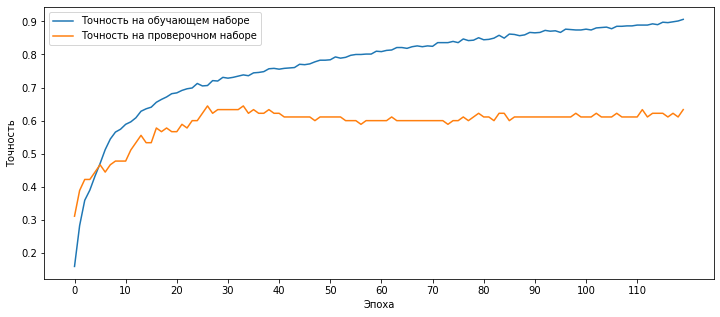

Точность в конце обучения: 0.9061728119850159 0.6333333253860474


In [ ]:
# Обучение малой модели: все параметры + синтетически добавленные (аугментированные)
model_small = create_train_small_classifier(range(x_train_aug.shape[1]),
                                            x_train=x_train_aug,
                                            y_train=y_train_aug,
                                            x_val=x_val_aug,
                                            y_val=y_val_aug)

Как можно видеть, после обучения точность на обучающей выборке выросла. С этим можно дальше работать, подбирая значимые признаки уже из расширенного множества.

---

**Наблюдение:** аугментация данных может улучшить результат на той же архитектуре!

---

В завершение рассмотрим архитектуры с активацией **softmax** в промежуточных слоях. Обычно данную активацию используют в конце модели для классификации, но никто не запрещает экспериментировать. Если применить **softmax** в промежуточном слое сети, получается некоторая промежуточная классификация по каким-то известным только модели внутренним классам; а вдруг это улучшит финальную точность модели?

Попробуем это проверить; вы уже знаете, что эксперименты могут помочь найти удачную архитектуру для модели.

##Архитектуры с softmax

Сконцентрируем в функции `compile_train()` код для сборки и обучения с одинаковыми тренировочными параметрами для будущих моделей:

In [ ]:
# Функция компиляции и обучения модели с одними и теми же параметрами

def compile_train(model,         # модель нейронной сети
                  epochs=300,    # количество эпох обучения
                  batch_size=20  # размер батча
                  ):
    # Компиляция
    model.compile(optimizer=Adam(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    # Обучение
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графика обучения
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.show()

Проведем серию экспериментов с различиными архитектурами с активацией **softmax** во внутренних слоях. Будем обучать экспериментальные модели на одном и том же количестве эпох и размере пакета.

Epoch 1/300
41/41 [==============================] - 1s 8ms/step - loss: 2.3397 - accuracy: 0.1284 - val_loss: 2.3458 - val_accuracy: 0.1111
Epoch 2/300
41/41 [==============================] - 0s 4ms/step - loss: 2.3094 - accuracy: 0.1506 - val_loss: 2.3130 - val_accuracy: 0.1556
Epoch 3/300
41/41 [==============================] - 0s 5ms/step - loss: 2.2820 - accuracy: 0.1790 - val_loss: 2.2835 - val_accuracy: 0.1889
Epoch 4/300
41/41 [==============================] - 0s 5ms/step - loss: 2.2576 - accuracy: 0.2111 - val_loss: 2.2558 - val_accuracy: 0.2000
Epoch 5/300
41/41 [==============================] - 0s 4ms/step - loss: 2.2344 - accuracy: 0.2383 - val_loss: 2.2311 - val_accuracy: 0.2333
Epoch 6/300
41/41 [==============================] - 0s 4ms/step - loss: 2.2129 - accuracy: 0.2543 - val_loss: 2.2076 - val_accuracy: 0.2778
Epoch 7/300
41/41 [==============================] - 0s 5ms/step - loss: 2.1921 - accuracy: 0.2753 - val_loss: 2.1852 - val_accuracy: 0.2889
Epoch 8/300
4

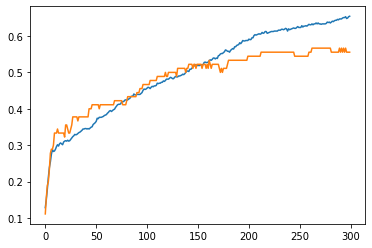

In [ ]:
# Сеть с разными ветками и активациями

# Вход
input1 = Input(x_train.shape[1:])

# Первая ветка с elu
x1 = Dense(10, activation="elu")(input1) 
x1 = Dense(10, activation="elu")(x1)

# Вторая ветка с softmaх
x2 = Dense(10, activation="elu")(input1)
x2 = Dense(40, activation="softmax")(x2)

# Объединение веток
x = concatenate([x1, x2])

# Финальные слои
x = Dense(10, activation='elu')(x)
x = Dense(10, activation='softmax')(x)

# Сборка модели
model = Model(input1, x)

compile_train(model)

В этой НС использовали две ветки после входа, и в одной из них – активацию **softmax**. Точность на проверочной выборке достигает примерно **55%**.

Epoch 1/300
41/41 [==============================] - 1s 9ms/step - loss: 2.5051 - accuracy: 0.1000 - val_loss: 2.4590 - val_accuracy: 0.1222
Epoch 2/300
41/41 [==============================] - 0s 4ms/step - loss: 2.4534 - accuracy: 0.1123 - val_loss: 2.4115 - val_accuracy: 0.1222
Epoch 3/300
41/41 [==============================] - 0s 4ms/step - loss: 2.4103 - accuracy: 0.1198 - val_loss: 2.3713 - val_accuracy: 0.1222
Epoch 4/300
41/41 [==============================] - 0s 4ms/step - loss: 2.3735 - accuracy: 0.1284 - val_loss: 2.3373 - val_accuracy: 0.1444
Epoch 5/300
41/41 [==============================] - 0s 4ms/step - loss: 2.3416 - accuracy: 0.1407 - val_loss: 2.3069 - val_accuracy: 0.1556
Epoch 6/300
41/41 [==============================] - 0s 4ms/step - loss: 2.3131 - accuracy: 0.1556 - val_loss: 2.2794 - val_accuracy: 0.1667
Epoch 7/300
41/41 [==============================] - 0s 4ms/step - loss: 2.2875 - accuracy: 0.1642 - val_loss: 2.2556 - val_accuracy: 0.1667
Epoch 8/300
4

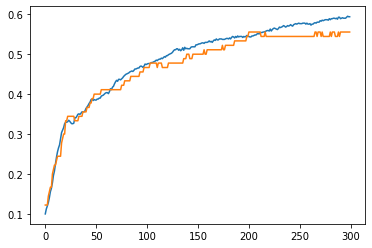

In [ ]:
# Облегченный вариант архитектуры

input1 = Input(x_train.shape[1:])

x1 = Dense(10, activation="elu")(input1)
x1 = Dense(10, activation="elu")(x1)

x = Dense(10, activation='elu')(x1)
x = Dense(10, activation='softmax')(x)

model = Model(input1, x)

compile_train(model)

Использовали подряд несколько полносвязных сетей. Точность на проверочной выборке – **55%**.

Epoch 1/300
41/41 [==============================] - 1s 12ms/step - loss: 2.2603 - accuracy: 0.1457 - val_loss: 2.1467 - val_accuracy: 0.2000
Epoch 2/300
41/41 [==============================] - 0s 6ms/step - loss: 2.0932 - accuracy: 0.2444 - val_loss: 2.0088 - val_accuracy: 0.2556
Epoch 3/300
41/41 [==============================] - 0s 6ms/step - loss: 1.9683 - accuracy: 0.3259 - val_loss: 1.8996 - val_accuracy: 0.3222
Epoch 4/300
41/41 [==============================] - 0s 6ms/step - loss: 1.8689 - accuracy: 0.3494 - val_loss: 1.8062 - val_accuracy: 0.3444
Epoch 5/300
41/41 [==============================] - 0s 7ms/step - loss: 1.7889 - accuracy: 0.3568 - val_loss: 1.7372 - val_accuracy: 0.3444
Epoch 6/300
41/41 [==============================] - 0s 6ms/step - loss: 1.7239 - accuracy: 0.3642 - val_loss: 1.6796 - val_accuracy: 0.3556
Epoch 7/300
41/41 [==============================] - 0s 6ms/step - loss: 1.6697 - accuracy: 0.3802 - val_loss: 1.6314 - val_accuracy: 0.3667
Epoch 8/300


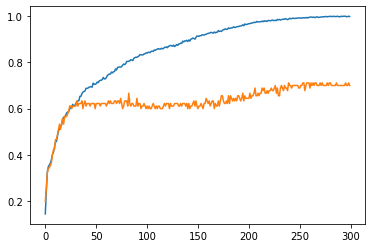

In [ ]:
# Сеть с 7 ветками, разным количеством нейронов и функциями активации

input1 = Input(x_train.shape[1:])

x1 = Dense(64, activation="elu")(input1)
x1 = Dense(64, activation="elu")(x1)

x2 = Dense(64, activation="elu")(input1)
x2 = Dense(40, activation="softmax")(x2)

x3 = Dense(64, activation="elu")(input1)
x3 = Dense(200, activation="softmax")(x3)

x4 = Dense(40, activation="softmax")(input1)

x5 = Dense(200, activation="softmax")(input1)

x6 = Dense(10, activation="softmax")(input1)

x7 = Dense(64, activation="elu")(input1)
x7 = Dense(10, activation="softmax")(x7)

x = concatenate([x1, x2, x3, x4, x5, x6, x7])

x = Dense(64, activation='elu')(x)
x = Dense(10, activation='softmax')(x)

model = Model(input1, x)

compile_train(model)

Теперь после входа использовали семь веток, и точность на протяжении обучения превышала **70%**. С некоторого момента началось переобучение.

Epoch 1/300
41/41 [==============================] - 4s 27ms/step - loss: 1.9408 - accuracy: 0.3333 - val_loss: 1.9320 - val_accuracy: 0.3778
Epoch 2/300
41/41 [==============================] - 1s 15ms/step - loss: 1.2525 - accuracy: 0.5617 - val_loss: 1.8254 - val_accuracy: 0.4000
Epoch 3/300
41/41 [==============================] - 1s 15ms/step - loss: 1.0892 - accuracy: 0.6383 - val_loss: 1.7130 - val_accuracy: 0.4000
Epoch 4/300
41/41 [==============================] - 1s 18ms/step - loss: 0.9783 - accuracy: 0.6580 - val_loss: 1.6506 - val_accuracy: 0.4333
Epoch 5/300
41/41 [==============================] - 1s 18ms/step - loss: 0.8992 - accuracy: 0.6988 - val_loss: 1.5631 - val_accuracy: 0.4667
Epoch 6/300
41/41 [==============================] - 1s 15ms/step - loss: 0.7988 - accuracy: 0.7531 - val_loss: 1.4929 - val_accuracy: 0.5111
Epoch 7/300
41/41 [==============================] - 1s 16ms/step - loss: 0.7377 - accuracy: 0.7667 - val_loss: 1.4088 - val_accuracy: 0.5556
Epoch 

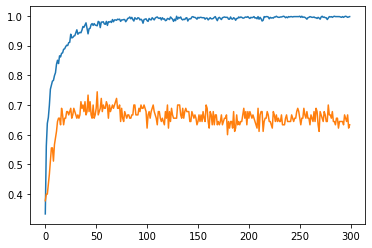

In [ ]:
# Сеть с измененным количеством нейронов в слоях и нормализацией после каждого слоя

input1 = Input(x_train.shape[1:])

x1 = Dense(256, activation="elu")(input1)
x1 = BatchNormalization()(x1)
x1 = Dense(256, activation="elu")(x1)
x1 = BatchNormalization()(x1)

x2 = Dense(256, activation="elu")(input1)
x2 = BatchNormalization()(x2)
x2 = Dense(40, activation="softmax")(x2)
x2 = BatchNormalization()(x2)

x3 = Dense(256, activation="elu")(input1)
x3 = BatchNormalization()(x3)
x3 = Dense(200, activation="softmax")(x3)
x3 = BatchNormalization()(x3)

x4 = Dense(40, activation="softmax")(input1)
x4 = BatchNormalization()(x4)

x5 = Dense(200, activation="softmax")(input1)
x5 = BatchNormalization()(x5)

x6 = Dense(10, activation="softmax")(input1)
x6 = BatchNormalization()(x6)

x7 = Dense(256, activation="elu")(input1)
x7 = BatchNormalization()(x7)
x7 = Dense(10, activation="softmax")(x7)
x7 = BatchNormalization()(x7)

x = concatenate([x1, x2, x3, x4, x5, x6, x7])

x = BatchNormalization()(x)
x = Dense(256, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='softmax')(x)

model = Model(input1, x)

compile_train(model)

В данной архитектуре использовали нормализацию, но окончательно справиться с переобучением не удалось. Результат на проверочной выборке остался в пределах **65%**:

Если получен удачный результат, полезно сохранить полную обученную модель для дальнейших исследований, или даже для промышленной эксплуатации:

In [ ]:
# Сохранение/восстановление модели
model.save('/content/model_audio_mean_advanced.h5')
model = load_model('/content/model_audio_mean_advanced.h5')

##Проверка точности предсказаний модели

Остановимся на последней модели и проведем проверку результатов по той же технологии, что и для самой первой модели.

Проверим точность:
* на данных проверочной выборки;
* на данных тестовой выборки;
* на некоторых аудиофайлах обучающего набора, чтобы убедиться, что обучающий набор хорошо распознается;
* на тестовых аудиофайлах, чтобы увидеть объективный результат на незнакомых для модели данных.

Попробуйте самостоятельно интерпретировать результаты по диаграммам распределения предсказаний модели и матрицам ошибок.


###Проверка на данных тестовой выборки

3/3 [==============================] - 0s 6ms/step - loss: 1.8443 - accuracy: 0.6333
Ошибка: 1.8442744016647339, точность: 0.6333333253860474


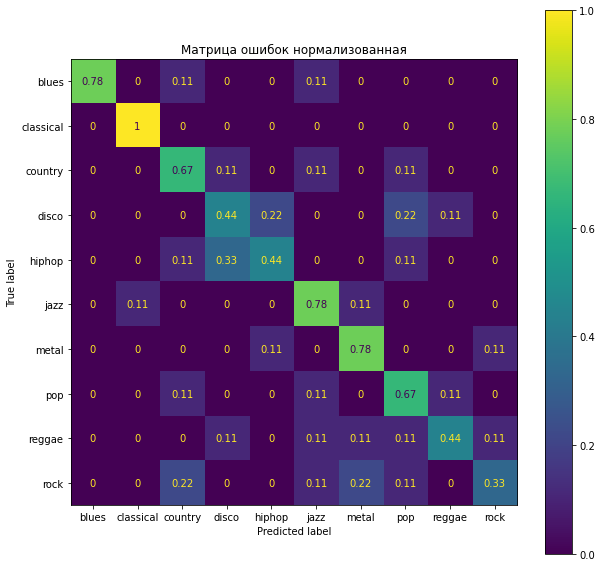

In [ ]:
# Оценка точности сети на проверочной выборке
eval_model(model, x_val, y_val)

4/4 [==============================] - 0s 6ms/step - loss: 2.3717 - accuracy: 0.6400
Ошибка: 2.3716957569122314, точность: 0.6399999856948853


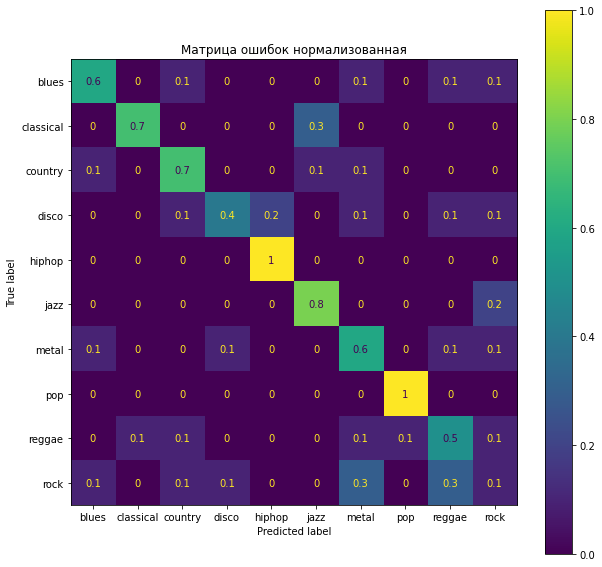

In [ ]:
# Оценка точности сети на тестовой выборке
eval_model(model, x_test, y_test)

###Проверка на звуковых файлах

###Визуализация на файлах тренировочного набора

Файл: ./genres/blues/blues.00050.au
Векторы для предсказания: (1, 37)
Классификация сети: blues - ВЕРНО :-)


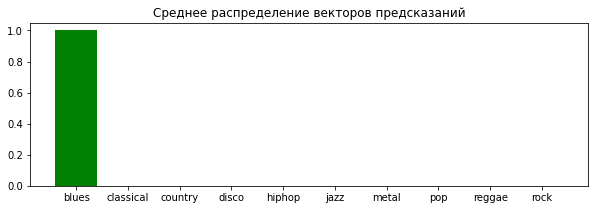

---------------------------------------------------------------
Файл: ./genres/blues/blues.00051.au
Векторы для предсказания: (1, 37)
Классификация сети: blues - ВЕРНО :-)


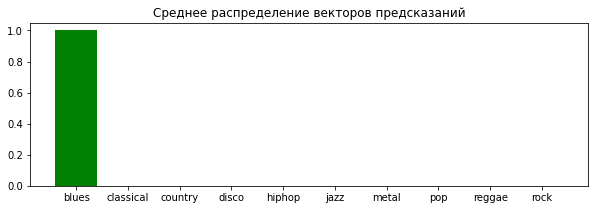

---------------------------------------------------------------
Файл: ./genres/blues/blues.00052.au
Векторы для предсказания: (1, 37)
Классификация сети: blues - ВЕРНО :-)


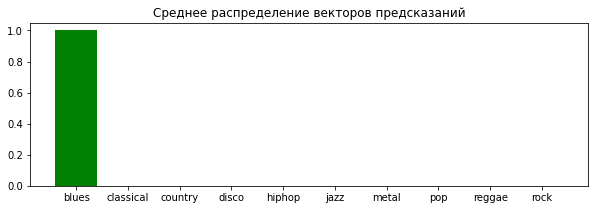

---------------------------------------------------------------
Файл: ./genres/blues/blues.00053.au
Векторы для предсказания: (1, 37)
Классификация сети: blues - ВЕРНО :-)


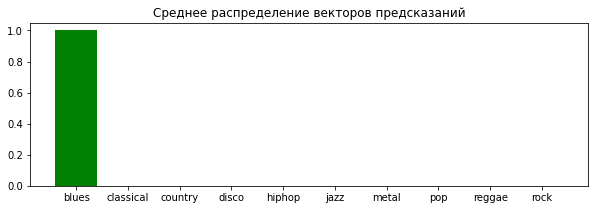

---------------------------------------------------------------
Файл: ./genres/blues/blues.00054.au
Векторы для предсказания: (1, 37)
Классификация сети: blues - ВЕРНО :-)


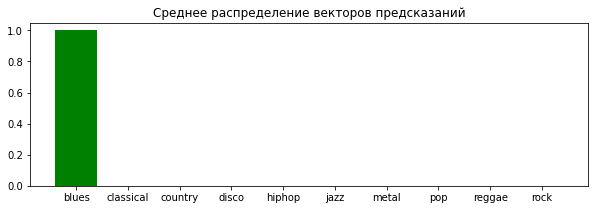

---------------------------------------------------------------
Файл: ./genres/classical/classical.00050.au
Векторы для предсказания: (1, 37)
Классификация сети: classical - ВЕРНО :-)


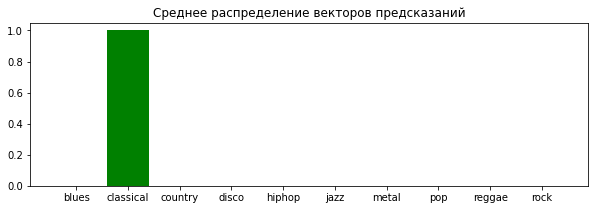

---------------------------------------------------------------
Файл: ./genres/classical/classical.00051.au
Векторы для предсказания: (1, 37)
Классификация сети: classical - ВЕРНО :-)


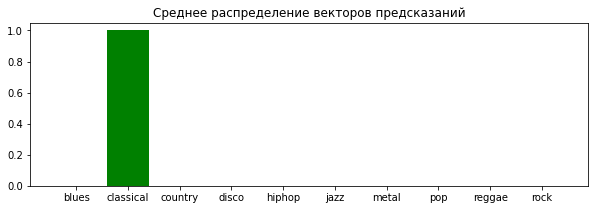

---------------------------------------------------------------
Файл: ./genres/classical/classical.00052.au
Векторы для предсказания: (1, 37)
Классификация сети: classical - ВЕРНО :-)


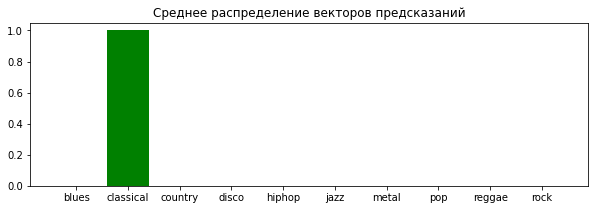

---------------------------------------------------------------
Файл: ./genres/classical/classical.00053.au
Векторы для предсказания: (1, 37)
Классификация сети: classical - ВЕРНО :-)


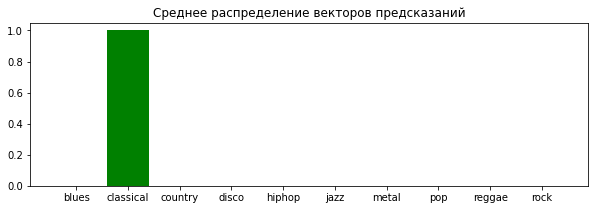

---------------------------------------------------------------
Файл: ./genres/classical/classical.00054.au
Векторы для предсказания: (1, 37)
Классификация сети: classical - ВЕРНО :-)


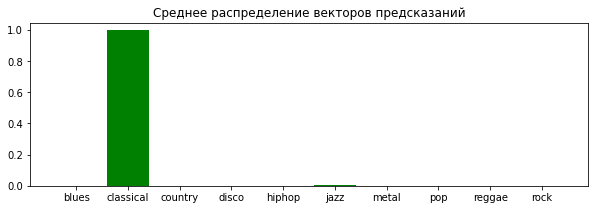

---------------------------------------------------------------
Файл: ./genres/country/country.00050.au
Векторы для предсказания: (1, 37)
Классификация сети: country - ВЕРНО :-)


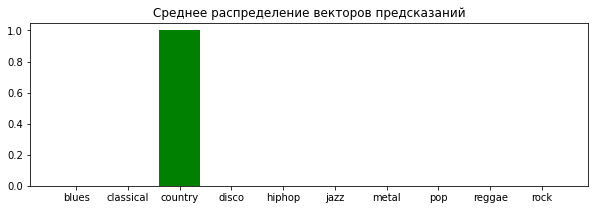

---------------------------------------------------------------
Файл: ./genres/country/country.00051.au
Векторы для предсказания: (1, 37)
Классификация сети: country - ВЕРНО :-)


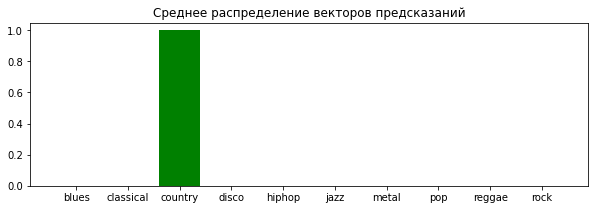

---------------------------------------------------------------
Файл: ./genres/country/country.00052.au
Векторы для предсказания: (1, 37)
Классификация сети: country - ВЕРНО :-)


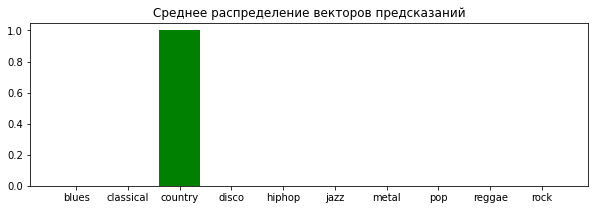

---------------------------------------------------------------
Файл: ./genres/country/country.00053.au
Векторы для предсказания: (1, 37)
Классификация сети: country - ВЕРНО :-)


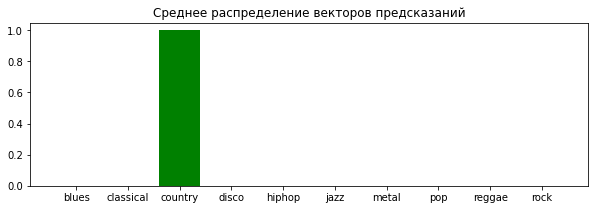

---------------------------------------------------------------
Файл: ./genres/country/country.00054.au
Векторы для предсказания: (1, 37)
Классификация сети: country - ВЕРНО :-)


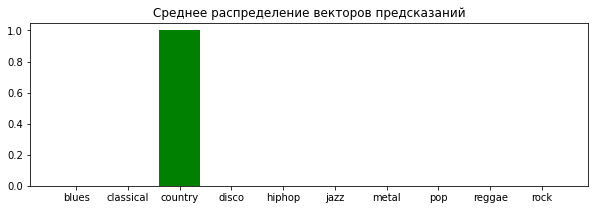

---------------------------------------------------------------
Файл: ./genres/disco/disco.00050.au
Векторы для предсказания: (1, 37)
Классификация сети: disco - ВЕРНО :-)


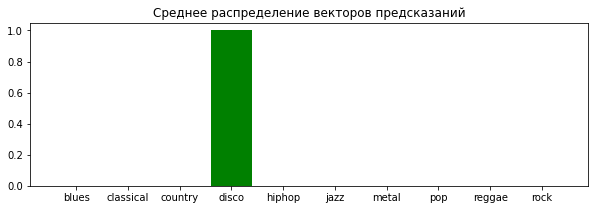

---------------------------------------------------------------
Файл: ./genres/disco/disco.00051.au
Векторы для предсказания: (1, 37)
Классификация сети: disco - ВЕРНО :-)


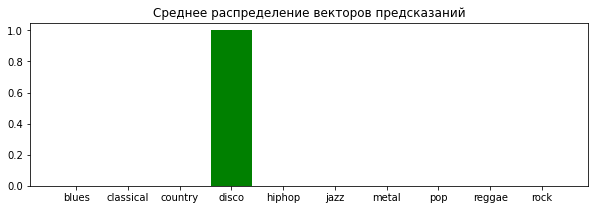

---------------------------------------------------------------
Файл: ./genres/disco/disco.00052.au
Векторы для предсказания: (1, 37)
Классификация сети: disco - ВЕРНО :-)


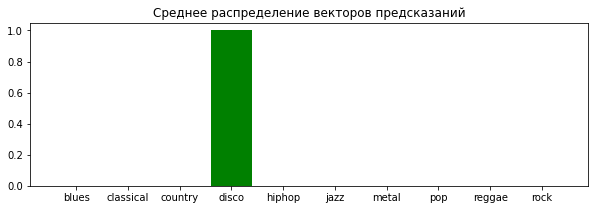

---------------------------------------------------------------
Файл: ./genres/disco/disco.00053.au
Векторы для предсказания: (1, 37)
Классификация сети: disco - ВЕРНО :-)


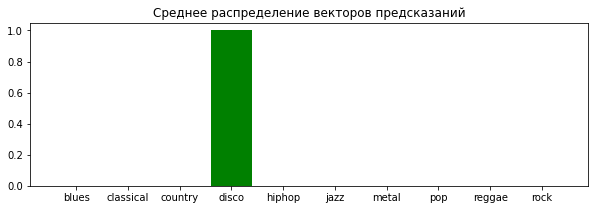

---------------------------------------------------------------
Файл: ./genres/disco/disco.00054.au
Векторы для предсказания: (1, 37)
Классификация сети: disco - ВЕРНО :-)


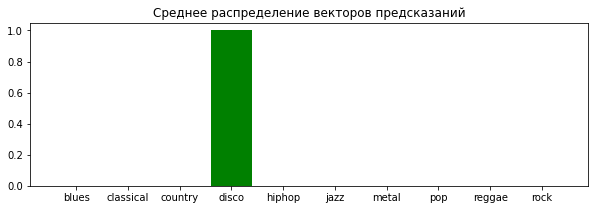

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00050.au
Векторы для предсказания: (1, 37)
Классификация сети: hiphop - ВЕРНО :-)


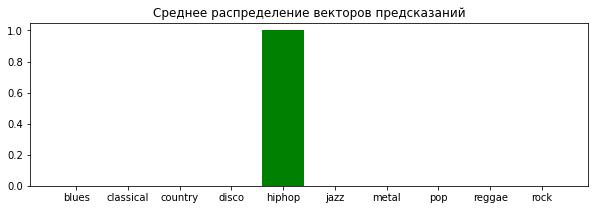

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00051.au
Векторы для предсказания: (1, 37)
Классификация сети: hiphop - ВЕРНО :-)


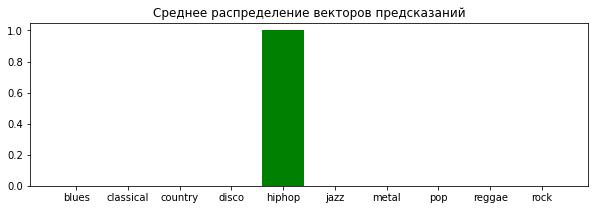

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00052.au
Векторы для предсказания: (1, 37)
Классификация сети: hiphop - ВЕРНО :-)


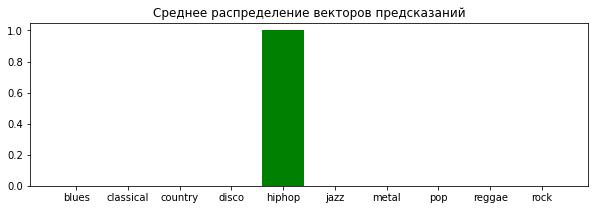

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00053.au
Векторы для предсказания: (1, 37)
Классификация сети: hiphop - ВЕРНО :-)


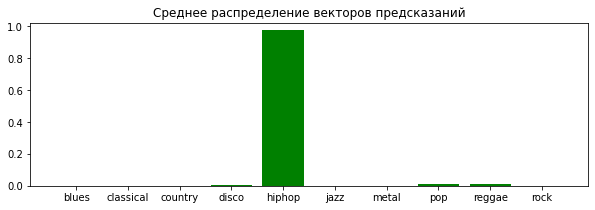

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00054.au
Векторы для предсказания: (1, 37)
Классификация сети: disco - НЕВЕРНО.


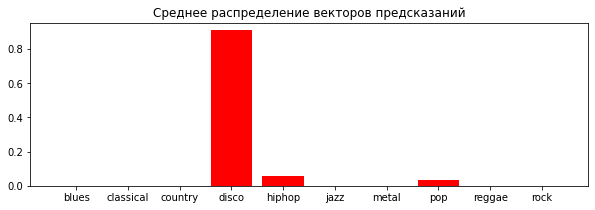

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00050.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - ВЕРНО :-)


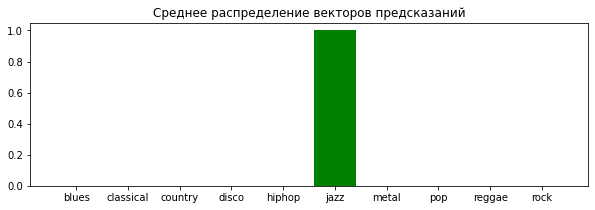

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00051.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - ВЕРНО :-)


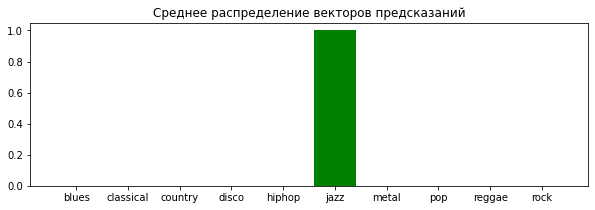

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00052.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - ВЕРНО :-)


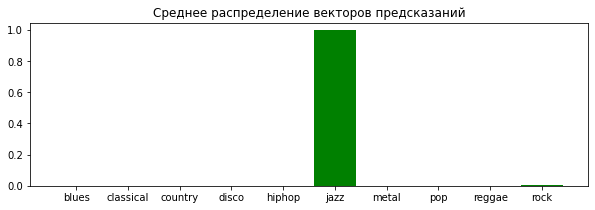

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00053.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - ВЕРНО :-)


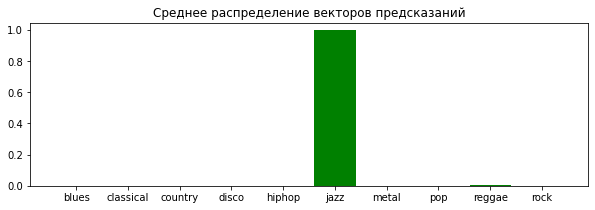

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00054.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - ВЕРНО :-)


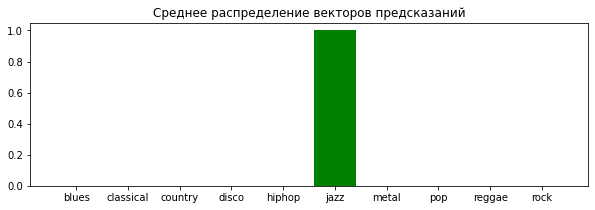

---------------------------------------------------------------
Файл: ./genres/metal/metal.00050.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - ВЕРНО :-)


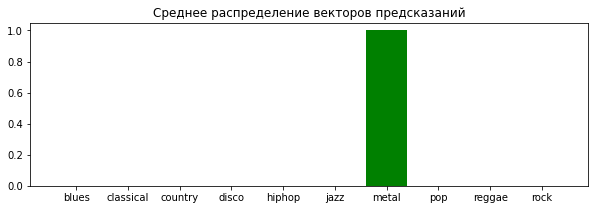

---------------------------------------------------------------
Файл: ./genres/metal/metal.00051.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - ВЕРНО :-)


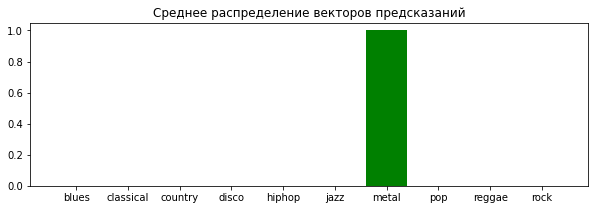

---------------------------------------------------------------
Файл: ./genres/metal/metal.00052.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - ВЕРНО :-)


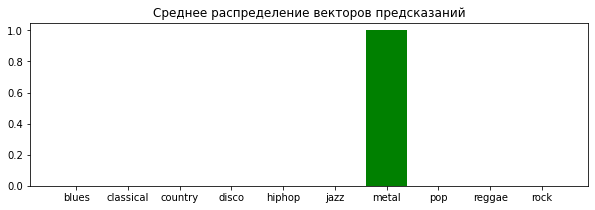

---------------------------------------------------------------
Файл: ./genres/metal/metal.00053.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - ВЕРНО :-)


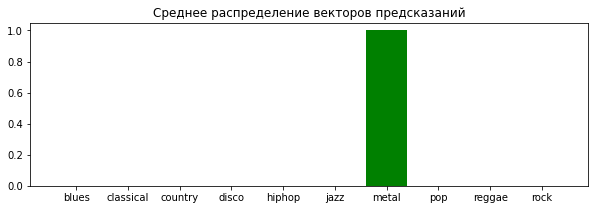

---------------------------------------------------------------
Файл: ./genres/metal/metal.00054.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - ВЕРНО :-)


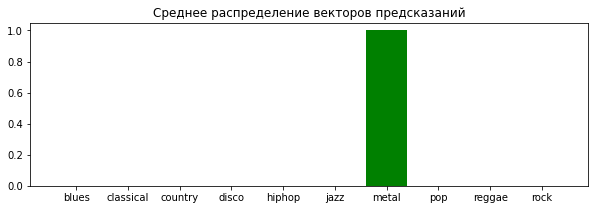

---------------------------------------------------------------
Файл: ./genres/pop/pop.00050.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - ВЕРНО :-)


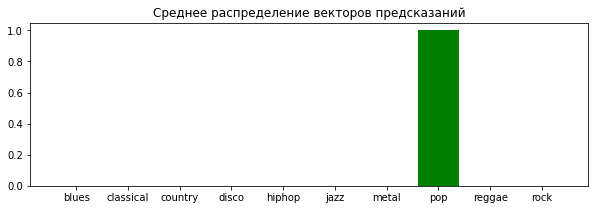

---------------------------------------------------------------
Файл: ./genres/pop/pop.00051.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - ВЕРНО :-)


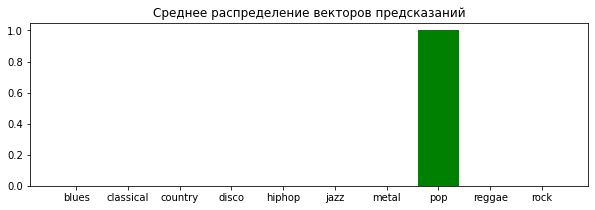

---------------------------------------------------------------
Файл: ./genres/pop/pop.00052.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - ВЕРНО :-)


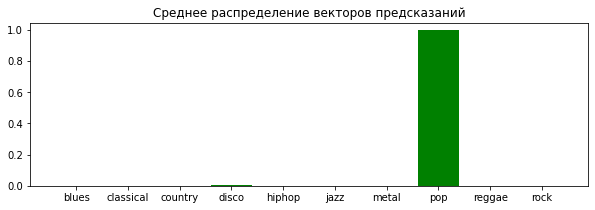

---------------------------------------------------------------
Файл: ./genres/pop/pop.00053.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - ВЕРНО :-)


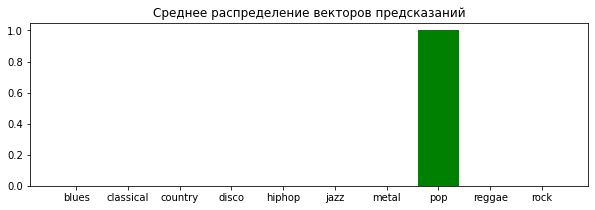

---------------------------------------------------------------
Файл: ./genres/pop/pop.00054.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - ВЕРНО :-)


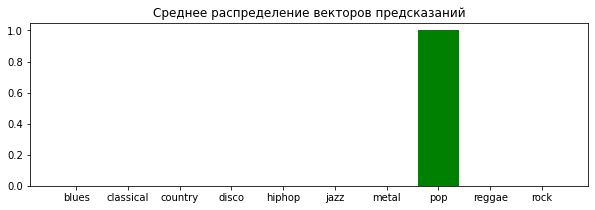

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00050.au
Векторы для предсказания: (1, 37)
Классификация сети: reggae - ВЕРНО :-)


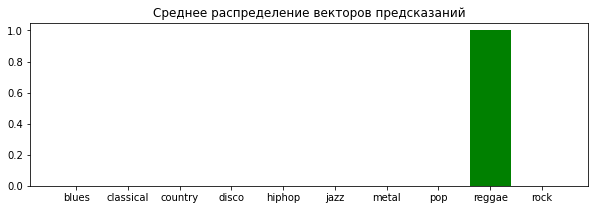

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00051.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - НЕВЕРНО.


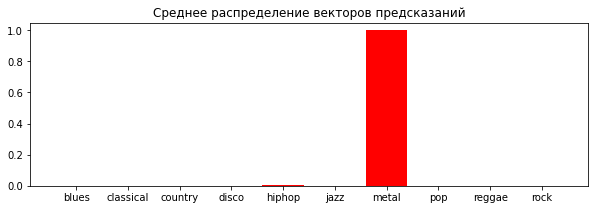

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00052.au
Векторы для предсказания: (1, 37)
Классификация сети: disco - НЕВЕРНО.


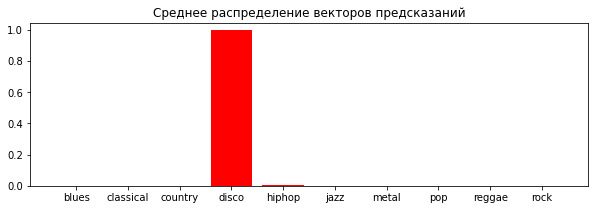

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00053.au
Векторы для предсказания: (1, 37)
Классификация сети: reggae - ВЕРНО :-)


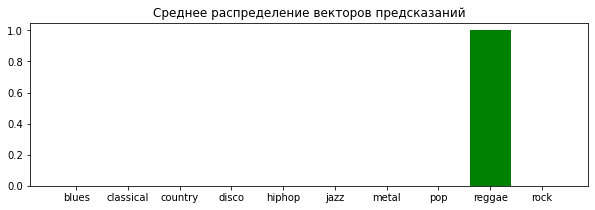

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00054.au
Векторы для предсказания: (1, 37)
Классификация сети: reggae - ВЕРНО :-)


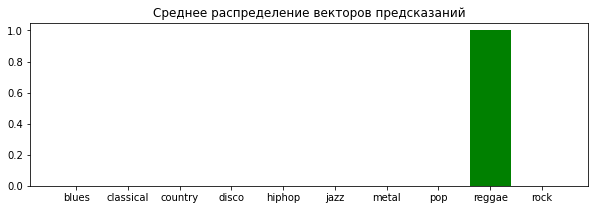

---------------------------------------------------------------
Файл: ./genres/rock/rock.00050.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - НЕВЕРНО.


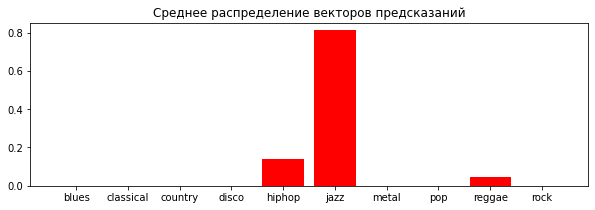

---------------------------------------------------------------
Файл: ./genres/rock/rock.00051.au
Векторы для предсказания: (1, 37)
Классификация сети: country - НЕВЕРНО.


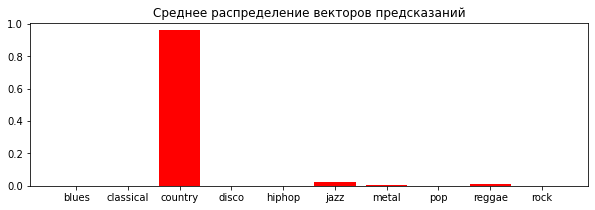

---------------------------------------------------------------
Файл: ./genres/rock/rock.00052.au
Векторы для предсказания: (1, 37)
Классификация сети: rock - ВЕРНО :-)


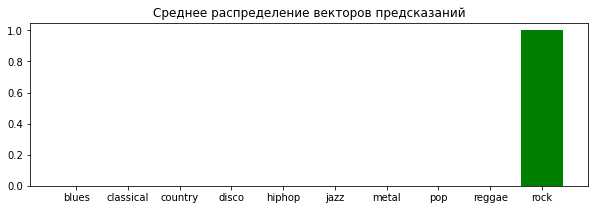

---------------------------------------------------------------
Файл: ./genres/rock/rock.00053.au
Векторы для предсказания: (1, 37)
Классификация сети: rock - ВЕРНО :-)


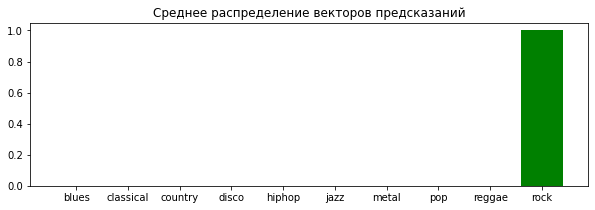

---------------------------------------------------------------
Файл: ./genres/rock/rock.00054.au
Векторы для предсказания: (1, 37)
Классификация сети: rock - ВЕРНО :-)


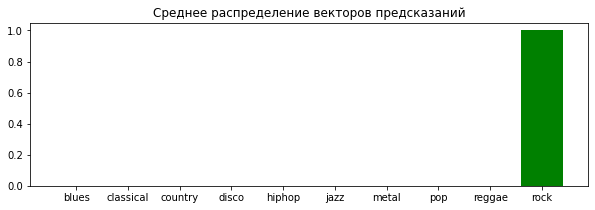

---------------------------------------------------------------
=== Обработано образцов: 50, из них распознано верно: 45, доля верных: 90.0% ===


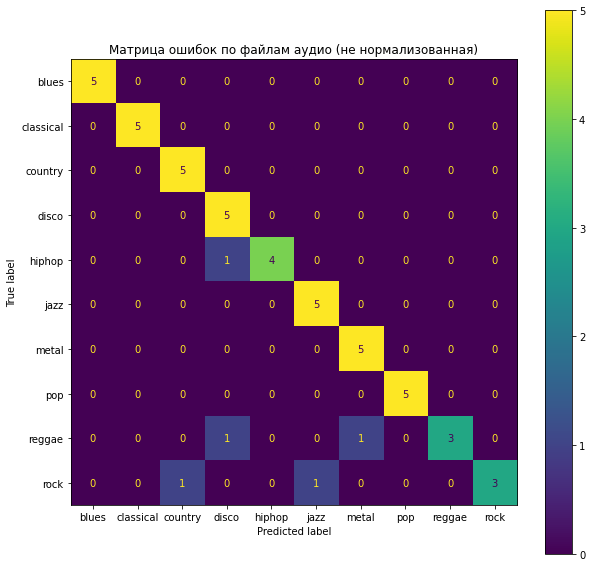

In [ ]:
# Визуализация классификации файлов из тренировочного набора
classify_test_files(model, x_scaler, 50, 5)

###Визуализация на файлах тестового набора

Файл: ./genres/blues/blues.00095.au
Векторы для предсказания: (1, 37)
Классификация сети: blues - ВЕРНО :-)


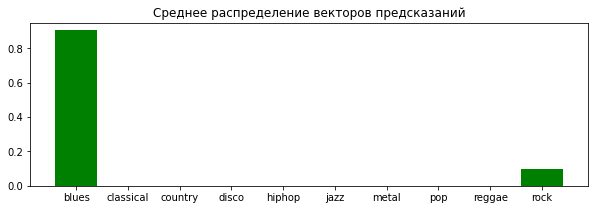

---------------------------------------------------------------
Файл: ./genres/blues/blues.00096.au
Векторы для предсказания: (1, 37)
Классификация сети: blues - ВЕРНО :-)


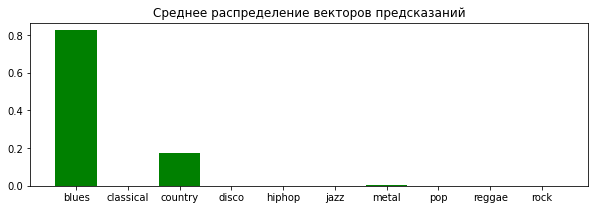

---------------------------------------------------------------
Файл: ./genres/blues/blues.00097.au
Векторы для предсказания: (1, 37)
Классификация сети: blues - ВЕРНО :-)


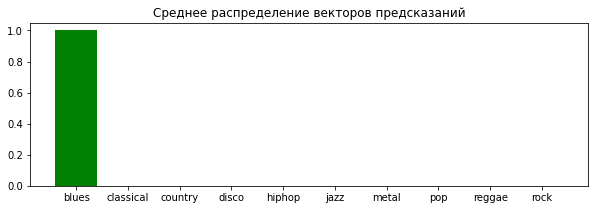

---------------------------------------------------------------
Файл: ./genres/blues/blues.00098.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - НЕВЕРНО.


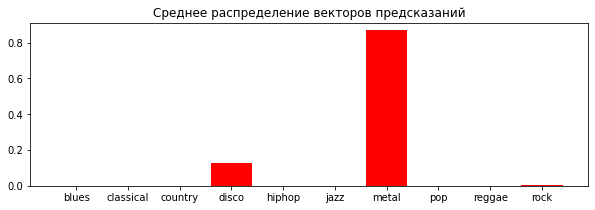

---------------------------------------------------------------
Файл: ./genres/blues/blues.00099.au
Векторы для предсказания: (1, 37)
Классификация сети: country - НЕВЕРНО.


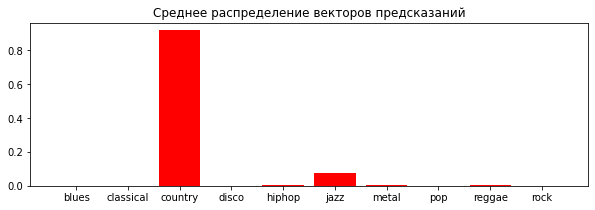

---------------------------------------------------------------
Файл: ./genres/classical/classical.00095.au
Векторы для предсказания: (1, 37)
Классификация сети: classical - ВЕРНО :-)


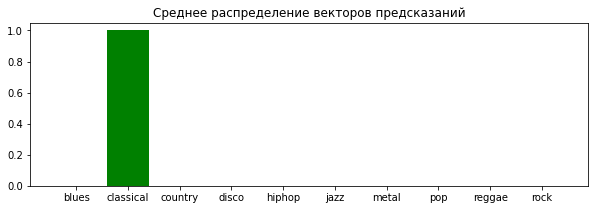

---------------------------------------------------------------
Файл: ./genres/classical/classical.00096.au
Векторы для предсказания: (1, 37)
Классификация сети: classical - ВЕРНО :-)


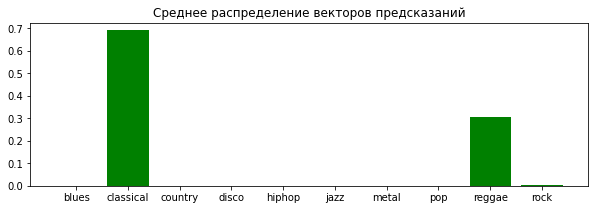

---------------------------------------------------------------
Файл: ./genres/classical/classical.00097.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - НЕВЕРНО.


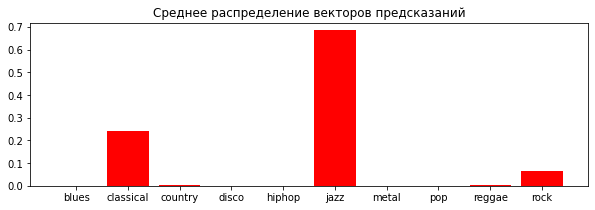

---------------------------------------------------------------
Файл: ./genres/classical/classical.00098.au
Векторы для предсказания: (1, 37)
Классификация сети: classical - ВЕРНО :-)


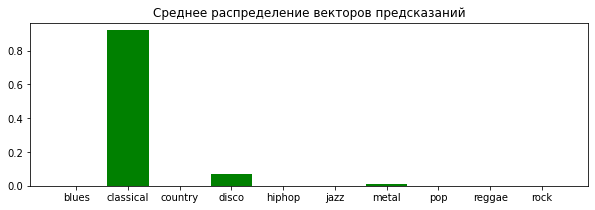

---------------------------------------------------------------
Файл: ./genres/classical/classical.00099.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - НЕВЕРНО.


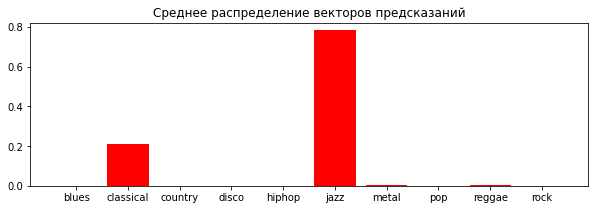

---------------------------------------------------------------
Файл: ./genres/country/country.00095.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - НЕВЕРНО.


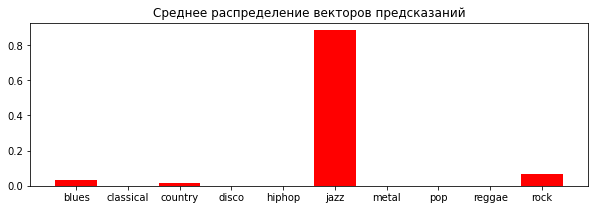

---------------------------------------------------------------
Файл: ./genres/country/country.00096.au
Векторы для предсказания: (1, 37)
Классификация сети: country - ВЕРНО :-)


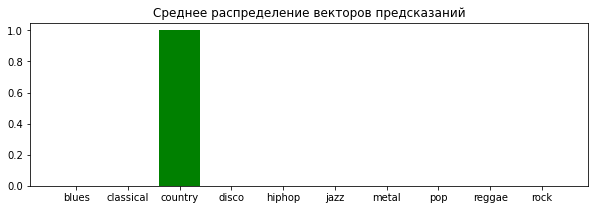

---------------------------------------------------------------
Файл: ./genres/country/country.00097.au
Векторы для предсказания: (1, 37)
Классификация сети: country - ВЕРНО :-)


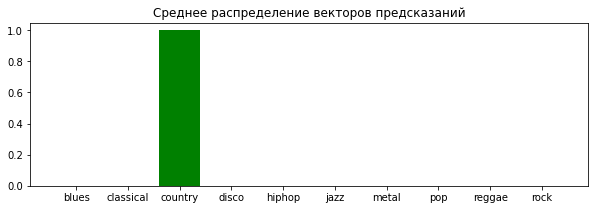

---------------------------------------------------------------
Файл: ./genres/country/country.00098.au
Векторы для предсказания: (1, 37)
Классификация сети: country - ВЕРНО :-)


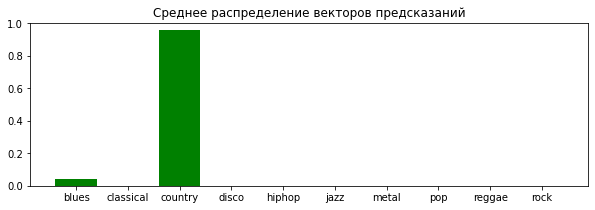

---------------------------------------------------------------
Файл: ./genres/country/country.00099.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - НЕВЕРНО.


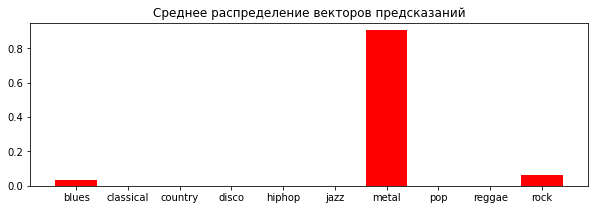

---------------------------------------------------------------
Файл: ./genres/disco/disco.00095.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - НЕВЕРНО.


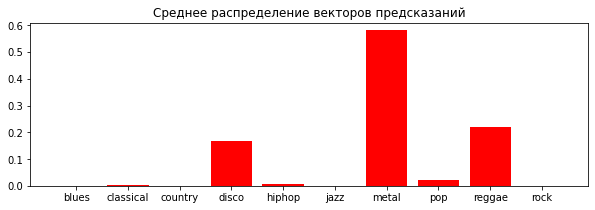

---------------------------------------------------------------
Файл: ./genres/disco/disco.00096.au
Векторы для предсказания: (1, 37)
Классификация сети: hiphop - НЕВЕРНО.


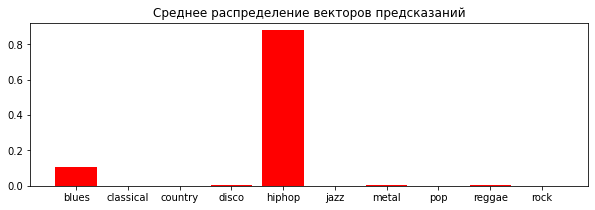

---------------------------------------------------------------
Файл: ./genres/disco/disco.00097.au
Векторы для предсказания: (1, 37)
Классификация сети: reggae - НЕВЕРНО.


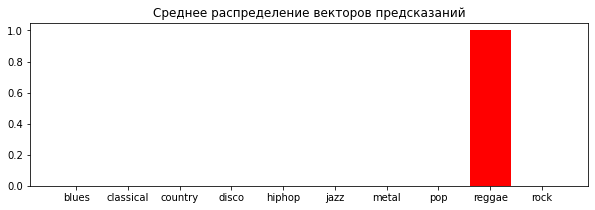

---------------------------------------------------------------
Файл: ./genres/disco/disco.00098.au
Векторы для предсказания: (1, 37)
Классификация сети: disco - ВЕРНО :-)


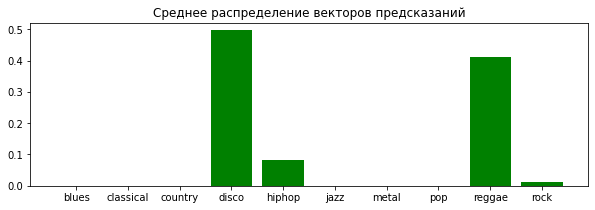

---------------------------------------------------------------
Файл: ./genres/disco/disco.00099.au
Векторы для предсказания: (1, 37)
Классификация сети: disco - ВЕРНО :-)


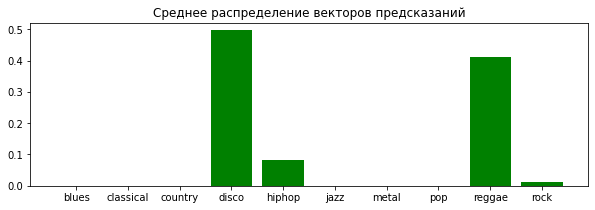

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00095.au
Векторы для предсказания: (1, 37)
Классификация сети: hiphop - ВЕРНО :-)


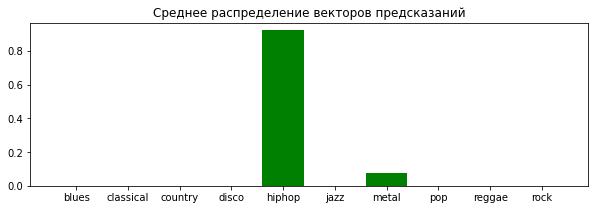

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00096.au
Векторы для предсказания: (1, 37)
Классификация сети: hiphop - ВЕРНО :-)


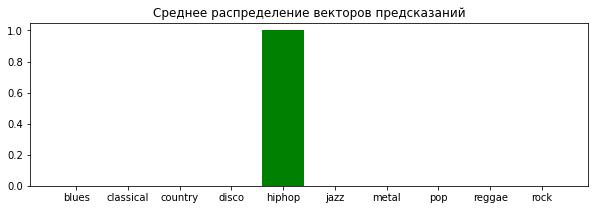

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00097.au
Векторы для предсказания: (1, 37)
Классификация сети: hiphop - ВЕРНО :-)


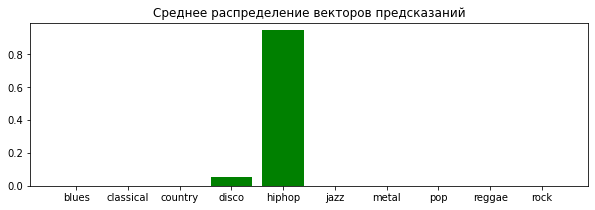

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00098.au
Векторы для предсказания: (1, 37)
Классификация сети: hiphop - ВЕРНО :-)


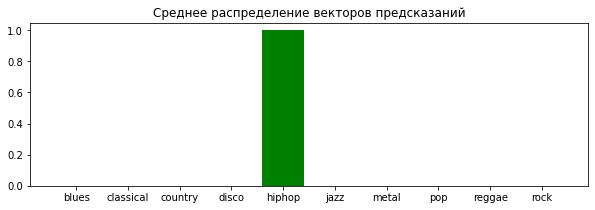

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00099.au
Векторы для предсказания: (1, 37)
Классификация сети: hiphop - ВЕРНО :-)


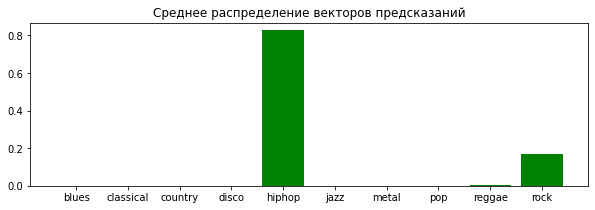

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00095.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - ВЕРНО :-)


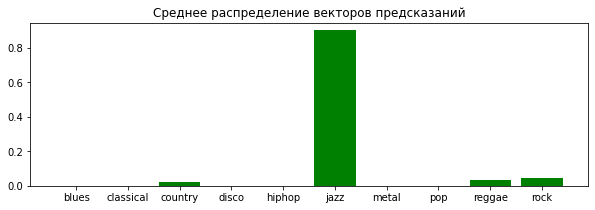

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00096.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - ВЕРНО :-)


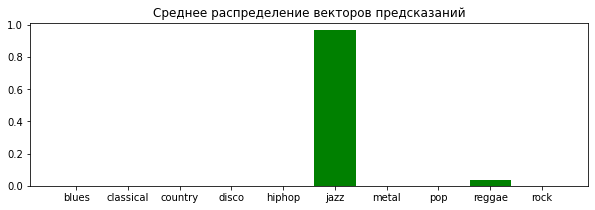

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00097.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - ВЕРНО :-)


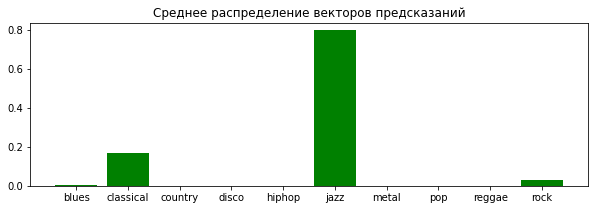

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00098.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - ВЕРНО :-)


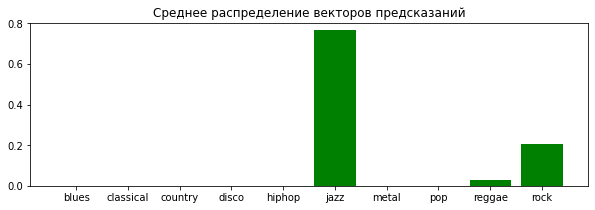

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00099.au
Векторы для предсказания: (1, 37)
Классификация сети: jazz - ВЕРНО :-)


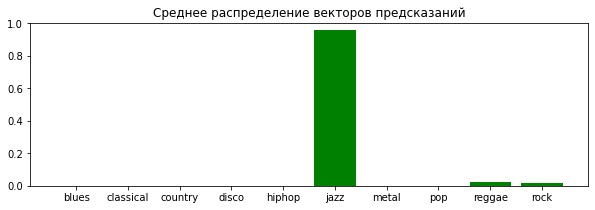

---------------------------------------------------------------
Файл: ./genres/metal/metal.00095.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - ВЕРНО :-)


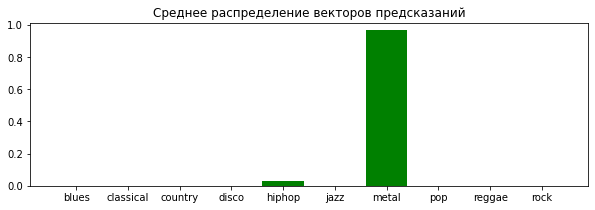

---------------------------------------------------------------
Файл: ./genres/metal/metal.00096.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - ВЕРНО :-)


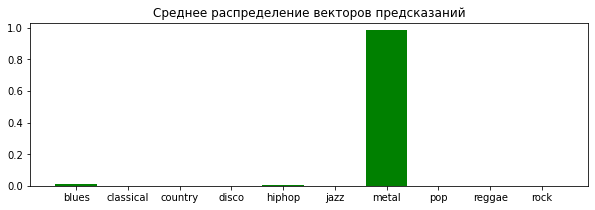

---------------------------------------------------------------
Файл: ./genres/metal/metal.00097.au
Векторы для предсказания: (1, 37)
Классификация сети: blues - НЕВЕРНО.


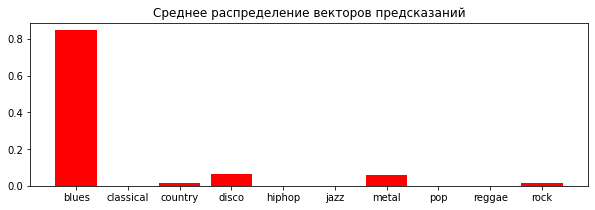

---------------------------------------------------------------
Файл: ./genres/metal/metal.00098.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - ВЕРНО :-)


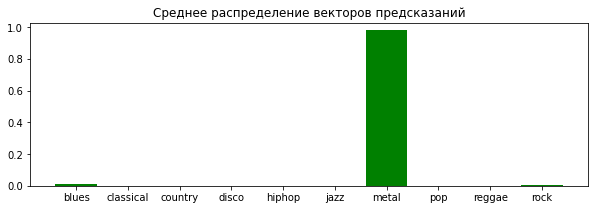

---------------------------------------------------------------
Файл: ./genres/metal/metal.00099.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - ВЕРНО :-)


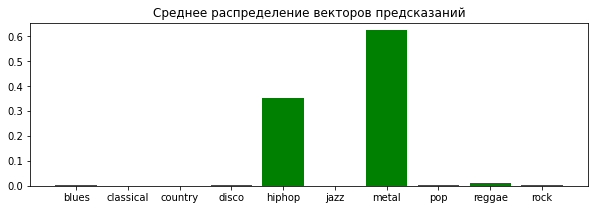

---------------------------------------------------------------
Файл: ./genres/pop/pop.00095.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - ВЕРНО :-)


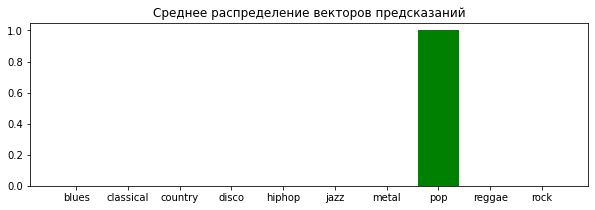

---------------------------------------------------------------
Файл: ./genres/pop/pop.00096.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - ВЕРНО :-)


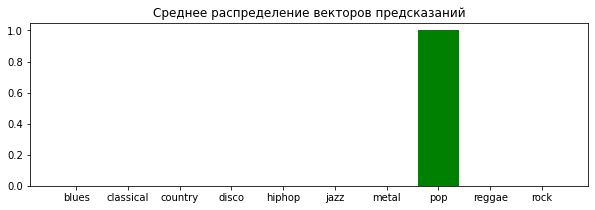

---------------------------------------------------------------
Файл: ./genres/pop/pop.00097.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - ВЕРНО :-)


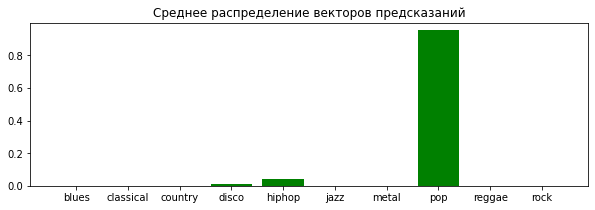

---------------------------------------------------------------
Файл: ./genres/pop/pop.00098.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - ВЕРНО :-)


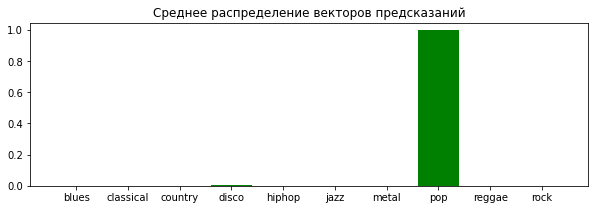

---------------------------------------------------------------
Файл: ./genres/pop/pop.00099.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - ВЕРНО :-)


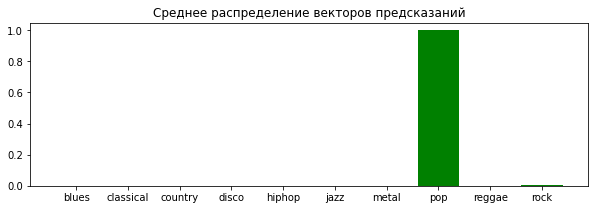

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00095.au
Векторы для предсказания: (1, 37)
Классификация сети: rock - НЕВЕРНО.


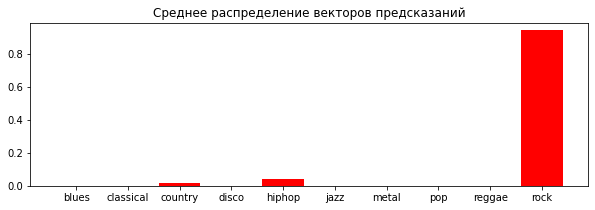

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00096.au
Векторы для предсказания: (1, 37)
Классификация сети: reggae - ВЕРНО :-)


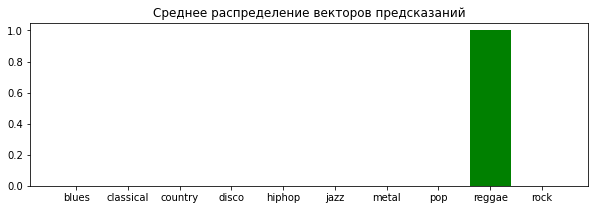

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00097.au
Векторы для предсказания: (1, 37)
Классификация сети: pop - НЕВЕРНО.


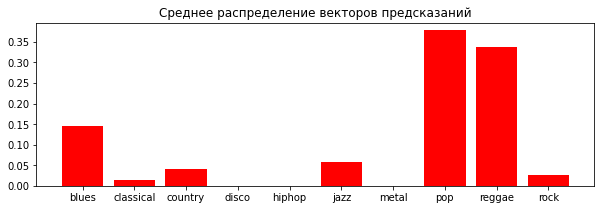

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00098.au
Векторы для предсказания: (1, 37)
Классификация сети: reggae - ВЕРНО :-)


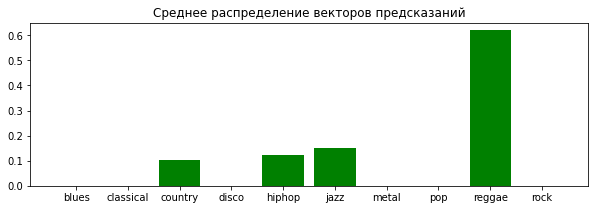

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00099.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - НЕВЕРНО.


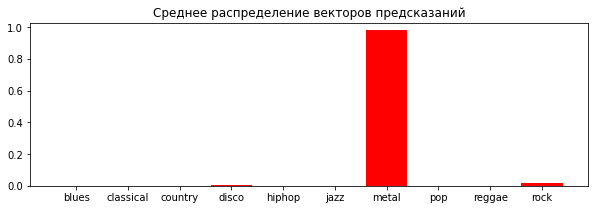

---------------------------------------------------------------
Файл: ./genres/rock/rock.00095.au
Векторы для предсказания: (1, 37)
Классификация сети: country - НЕВЕРНО.


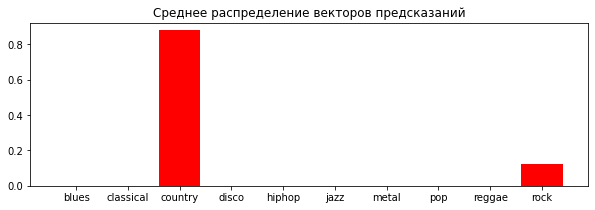

---------------------------------------------------------------
Файл: ./genres/rock/rock.00096.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - НЕВЕРНО.


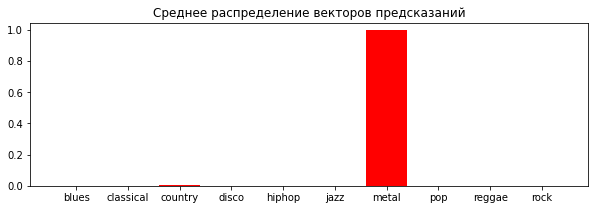

---------------------------------------------------------------
Файл: ./genres/rock/rock.00097.au
Векторы для предсказания: (1, 37)
Классификация сети: metal - НЕВЕРНО.


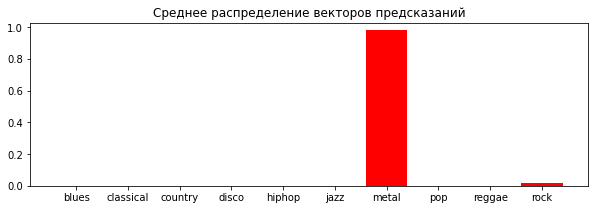

---------------------------------------------------------------
Файл: ./genres/rock/rock.00098.au
Векторы для предсказания: (1, 37)
Классификация сети: reggae - НЕВЕРНО.


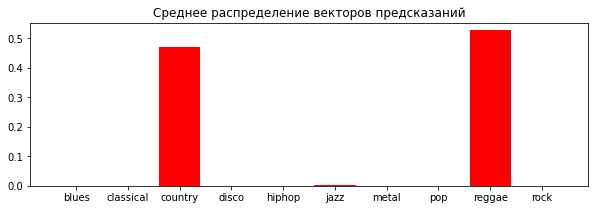

---------------------------------------------------------------
Файл: ./genres/rock/rock.00099.au
Векторы для предсказания: (1, 37)
Классификация сети: reggae - НЕВЕРНО.


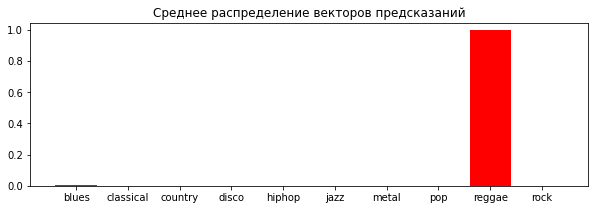

---------------------------------------------------------------
=== Обработано образцов: 50, из них распознано верно: 32, доля верных: 64.0% ===


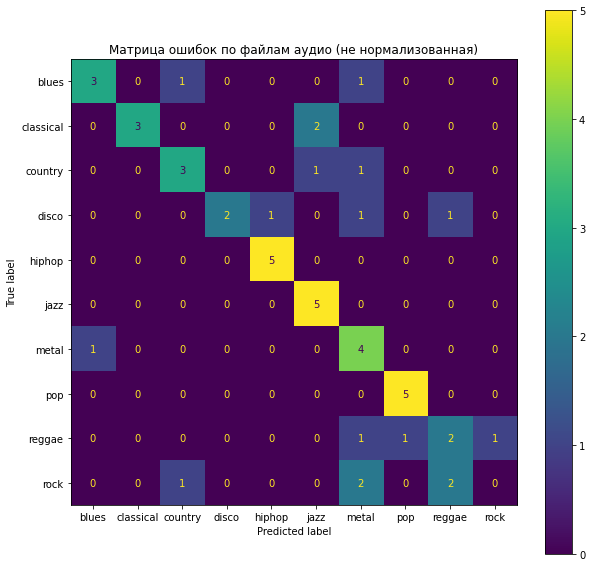

In [ ]:
# Визуализация классификации файлов из тестового набора
classify_test_files(model, x_scaler, 95, 5)

Вы провели множество экспериментов и изучили методики подбора архитектур, аугментации данных, проверки точности и визуализации результатов работы модели.

Следующий ноутбук повторяет код только что изученного, за исключением того, что используется значительно более объемный набор входных признаков за счет другого способа параметризации аудио (без усреднения по всему файлу).

Сравните подходы к решению задачи и получившиеся результаты.

**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1RaiYPz-2sS-EReNQL7tW6ms8ZuZphJLS?usp=sharing)

2. [Практика 1](https://colab.research.google.com/drive/1rd5i7URs1v_P8-KveFGFAQJ9thayJk1c?usp=sharing)

3. Практика 2

4. [Практика 3](https://colab.research.google.com/drive/1IX8zahyU01Nl0rm8dCsCrhY_l_UqDjRA?usp=sharing)
